<a href="https://colab.research.google.com/github/paridhika/DDL/blob/main/Latency_cost.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Initializing different DNN Models  
1.   ResNet50
2.   ResNet152
3.   VGG16
4.   InceptionResNetV2
5.   MobileNet


In [1]:
from keras.api._v2.keras.layers import Activation
import tensorflow as tf
import numpy as np


class Model:

    def __init__(self,name, model):
      self.model = model
      self.name = name
      self.layer_AI = []
      self.layer_AP = []
      # self.compute_model()


    # model_input_shape = (batch_size, 224, 224, 3)

    # Define a function to compute the number of operations for a Conv2D layer
    def compute_ops_conv2d(self,layer):
        kernel_size = layer.kernel_size[0]
        in_channels = layer.input_shape[-1]
        out_channels = layer.output_shape[-1]
        input_height, input_width = layer.input_shape[1:3]
        output_height, output_width = layer.output_shape[1:3]
        ops = kernel_size**2 * in_channels * output_height * output_width * out_channels
        return ops

    # Define a function to compute the number of operations for a MaxPooling2D layer
    def compute_ops_maxpool2d(self,layer):
        pool_size = layer.pool_size[0]
        in_channels = layer.input_shape[-1]
        input_height, input_width = layer.input_shape[1:3]
        output_height, output_width = layer.output_shape[1:3]
        ops = pool_size**2 * in_channels * output_height * output_width
        return ops

    # Define a function to compute the number of operations for a BatchNormalization layer
    def compute_ops_batchnorm(self,layer):
        # Get input shape
        input_shape = layer.input_shape[1:]
        in_channels = input_shape[-1]

        # Number of operations per element (2 for mean and variance)
        ops = 2 * in_channels

        return ops

    # Define a function to compute the number of operations for a ReLU layer
    def compute_ops_relu(self,layer):

        input_shape = layer.input_shape[1:]
        # Number of operations per element
        ops = 1
        for dim in input_shape:
            ops *= dim

        return ops

    # Define a function to compute the number of operations for the output layer
    def compute_ops_output(self,layer):
        num_input_channels = layer.input_shape[-1]
        num_output_channels = layer.output_shape[-1]
        fc_ops = (num_input_channels * num_output_channels) + num_output_channels
        if type(layer.activation) == tf.keras.activations.softmax or type(layer.activation) == tf.keras.activations.sigmoid:
            num_elements = tf.reduce_prod(layer.output_shape[1:])
            act_ops = num_elements
        else:
            act_ops = 0
        ops = fc_ops + act_ops
        return ops

    # Define a function to compute the number of operations for a padding layer
    def compute_ops_pad(self,layer):
        in_channels = layer.input_shape[-1]
        input_height, input_width = layer.input_shape[1:3]
        # Get the padding parameter from the layer's configuration
        padding = layer.get_config()['padding']

        top_padding = padding[0][0]
        bottom_padding = padding[0][1]
        left_padding = padding[1][0]
        right_padding = padding[1][1]
        total_padding = top_padding + bottom_padding + left_padding + right_padding
        ops = 2 * in_channels * input_height * input_width * total_padding
        return ops

    # Define a function to compute the number of operations for a padding layer
    def compute_ops_add(self,layer):
        in_channels = layer.input_shape[0][-1]
        input_height, input_width = layer.input_shape[0][1:3]
        ops = 2 * in_channels * input_height * input_width
        return ops
    # Print the number of operations for each layer in the model


    def compute_model(self):

        i = 0
        # Define a dictionary to store the number of operations for each layer
        ops_dict = {}
        # Compute the number of operations for each layer in the model
        for layer in self.model.layers:
            if isinstance(layer, tf.keras.layers.Conv2D):
                ops = self.compute_ops_conv2d(layer)
            elif isinstance(layer, tf.keras.layers.MaxPooling2D):
                ops = self.compute_ops_maxpool2d(layer)
            elif isinstance(layer, tf.keras.layers.BatchNormalization):
                ops = self.compute_ops_batchnorm(layer)
            elif isinstance(layer, tf.keras.layers.Activation):
                ops = self.compute_ops_relu(layer)
            elif isinstance(layer, tf.keras.layers.Dense):
                ops = self.compute_ops_output(layer)
            elif "pad" in layer.name:
                ops = self.compute_ops_pad(layer)
            elif "add" in layer.name:
                ops = self.compute_ops_add(layer)
            else:
                ops = 0
            ops_dict[layer.name] = [ops, layer.input_shape, layer.output_shape]
            # print(layer.get_config())

        ct = 1

        for layer_name, (ops, inp, out) in ops_dict.items():
            inp_size = 0

            if inp[0] is not None:
              (n,l,h,w) = inp[0]
              inp_size += l*h*w/1000000

              if len(inp) == 2:
                (n,l,h,w) = inp[1]
                inp_size += l*h*w/1000000

            elif len(inp) > 2:
              inp_size += inp[1]*inp[2] * inp[3]/1000000
            else:
              inp_size += inp[1]/1000000

            if i == 0:
              (n,l,h,w) = inp[0]
              i = i+10
              params = l*h*w
            # print(layer_name, ops, inp_size)
            if ops != 0:
              # print(layer_name, ops, layer.input_shape)
              self.layer_AP.append((self.batch_size * ops)/1000000000)
              self.layer_AI.append(self.batch_size * inp_size * 8)
            # else:
            #   print(layer_name, ops, layer.input_shape)
            #   print(ct)
            # ct = ct + 1
        self.layer_AI = [self.batch_size * x for x in self.layer_AI]
        self.sum = sum(self.layer_AP[0:len(self.layer_AP)])
        self.ratio = self.sum/(self.layer_AI[0])

# Models = [MobileNet, ResNet50, ResNet101, VGG16, InceptionResNetV2]
Models = []

# Instantiate the MobileNetV3Large model
model =  tf.keras.applications.MobileNetV2(weights='imagenet')
MobileNetV2 = Model("MobileNetV2",model)
Models.append(MobileNetV2)

# Instantiate the ResNet50 model
model =  tf.keras.applications.resnet.ResNet50(weights='imagenet')
ResNet50 = Model("ResNet50",model)
Models.append(ResNet50)

# Instantiate the ResNet101 model
model =  tf.keras.applications.resnet.ResNet101(weights='imagenet')
ResNet101 = Model("ResNet101",model)
Models.append(ResNet101)

model = tf.keras.applications.vgg16.VGG16(weights='imagenet')
VGG16 = Model("VGG16",model)
Models.append(VGG16)

model =  tf.keras.applications.resnet.ResNet152(weights='imagenet')
ResNet152 = Model("ResNet152",model)
# Models.append(ResNet152)

model =  tf.keras.applications.InceptionResNetV2(weights='imagenet')
InceptionResNetV2 = Model("InceptionResNetV2",model)
Models.append(InceptionResNetV2)

# Instantiate the EfficientNetB0 model
# model =  tf.keras.applications.EfficientNetB0(weights='imagenet')
# EfficientNetB0 = Model("EfficientNetB0",model)
# Models.append(EfficientNetB0)



225209952/225209952 [==============================] - 1s 0us/step


 # Class for Infrastructure

In [2]:
import matplotlib.pyplot as plt
import numpy as np

import csv
class Infrastructure:

    def __init__(self, edge,ne,cloud, UtilizationEdge, UtilizationNE, EetoNE, EetoC, NEtoC, PDEtoNE, PDEtoC):
        self.edge = edge
        self.ne = ne
        self.cloud = cloud
        self.EeP = EeP_Values[edge]
        self.UtilizationEdge = UtilizationEdge
        self.NEnP = ne_ct * NEnP_Values[ne]
        self.UtilizationNE = UtilizationNE
        self.CrP = c_ct * CrP_Values[cloud]
        self.EetoNE = EetoNE
        self.EetoC = EetoC
        self.NEtoC = NEtoC
        self.PDEtoNE = PDEtoNE
        self.PDEtoC = PDEtoC
        self.EeC = EeC_Values[edge]
        self.NEnC = ne_ct * NEnC_Values[ne]
        self.CrC = c_ct * CrC_Values[cloud]
        self.compute_constants()
        # self.check_condition()
        self.compute_model_latency()


    def print_configuration(self):
        print("Edge -> " + Device[self.edge] + " Utilization = " + str(self.UtilizationEdge) )
        print("NE -> " + NE[self.ne] + " Utilization = " + str(self.UtilizationNE) )
        print("Cloud -> " + Cloud[self.cloud]  )
        print("Bandwidth Edge to NE (Mbps) = " + str(self.EetoNE))
        print("Bandwidth Edge to Cloud (Mbps) = " + str(self.EetoC))
        print("Bandwidth NE to Cloud (Mbps) = " + str(self.NEtoC))
        print("Propagation Edge to NE (sec)= " + str(self.PDEtoNE))
        print("Propagation Edge to Cloud (sec) = " + str(self.PDEtoC))
        print("Network Transmission Cost (USD/sec) = " + str(self.NTrCEtoNE))
        print("Network Transmission Cost (USD/sec) = " + str(self.NTrCEtoC))
        print("Network Transmission Cost (USD/sec) = " + str(self.NTrCNEtoC))


    def compute_constants(self):
        self.alphaL = 1/(self.EeP * self.UtilizationEdge)
        self.alphaC = self.EeC * self.alphaL
        self.betaL = 1/(self.NEnP * self.UtilizationNE)
        self.betaC = self.NEnC * self.betaL
        self.gammaL = 1/self.CrP
        self.gammaC = self.CrC * self.gammaL
        # self.sigmaL = 1/self.EetoNE
        # self.tauL = 1/self.EetoC
        self.NTrCEtoNE = ((self.alphaC - self.betaC) / (self.alphaL-self.betaL))
        self.NTrCEtoC = ((self.alphaC - self.gammaC) / (self.alphaL-self.gammaL))
        self.NTrCNEtoC = ((self.betaC - self.gammaC) / (self.betaL-self.gammaL))
        self.alpha = self.alphaL/self.betaL
        self.beta = self.EeC/self.NEnC

    def compute_condition_Edge_equal_NE():
        self.edge_NE_ratio = (self.alpha*self.beta -1 )/(self.alpha-1)

    def compute_model_latency(self):
        self.edge_latency = []
        self.NE_latency = []
        self.edge_cost = []
        self.NE_cost = []

        for model in Models:
            self.edge_latency.append(self.compute_latency_Edge(model.sum))
            self.NE_latency.append(self.compute_latency_NE(model.sum,model.layer_AI[0]))
            self.edge_cost.append(self.compute_cost_Edge(model.sum))
            self.NE_cost.append(self.compute_cost_NE(model.sum,model.layer_AI[0]))

    def check_condition(self):
        if self.alphaL > self.betaL and self.betaL > self.gammaL and self.alphaC > self.betaC and self.betaC > self.gammaC:
          return True

    def compute_k(self):
        return (self.NEnP * self.UtilizationNE)/(self.EeP * self.UtilizationEdge)

    def compute_s(self):
        return self.CrP / (self.NEnP * self.UtilizationNE)

    # Functions for computing latency
    def compute_latency_Edge(self,AP):
      return AP*self.alphaL

    def compute_comm_NE(self,AI,EetoNE):
        if AI == 0:
          return 0
        return (AI/self.EetoNE) + self.PDEtoNE

    def compute_proc_NE(self,AP):
        if AP == 0:
          return 0
        return (AP*self.betaL)

    def compute_latency_NE(self, AP, AI):
      return  self.compute_comm_NE(AI,self.EetoNE) + self.compute_proc_NE(AP)

    def compute_latency_Cloud(self, AP, AI):
      if AI == 0 or AP == 0:
        return 0
      return (AI/self.EetoC) + self.PDEtoC + (AP*self.gammaL)

    def compute_latency_NE_Cloud(self, AP, AI):
      return (AI/self.NEtoC) + self.PDEtoC - self.PDEtoNE + (AP*self.gammaL)

    # Functions for computing cost
    def compute_cost_Edge(self,AP):
      return AP*self.alphaC

    def compute_cost_NE(self, AP, AI):
      if AI == 0 or AP == 0:
        return 0
      transmission_cost = ((AI/self.EetoNE) + self.PDEtoNE) * self.NTrCEtoNE
      computation_cost = AP*self.betaC

      return transmission_cost + computation_cost

    def compute_cost_Cloud(self, AP, AI):
      if AI == 0 or AP == 0:
        return 0
      transmission_cost = ((AI/self.EetoC) + self.PDEtoC) * self.NTrCEtoC
      computation_cost = AP*self.gammaC
      return transmission_cost + computation_cost

    def compute_cost_NE_Cloud(self, AP, AI):
      if AI == 0 or AP == 0:
        return 0
      transmission_cost = ((AI/self.NEtoC) + self.PDEtoC - self.PDEtoNE) * self.NTrCEtoC
      computation_cost = AP*self.gammaC
      return transmission_cost + computation_cost

    # Computation for AD vs AP plots
    # Compute slope and intercept for latency equations
    def compute_latency_m1(self):
      denom = (self.alphaL - self.betaL)
      return 1/(self.EetoNE * denom)

    def compute_latency_c1(self):
        denom = (self.alphaL - self.betaL)
        return self.PDEtoNE/denom

    def compute_latency_m2(self):
      denom = (self.alphaL - self.gammaL)
      return 1/(self.EetoC * denom)

    def compute_latency_c2(self):
        denom = (self.alphaL - self.gammaL)
        return self.PDEtoC/denom

    def compute_latency_m3(self):
        denom = (self.betaL - self.gammaL)
        return ((1/self.EetoC) - (1/self.EetoNE)) / denom

    def compute_latency_c3(self):
        denom = (self.betaL - self.gammaL)
        return (self.PDEtoC - self.PDEtoNE) / denom

    # Compute slope and intercept for cost equations
    def compute_cost_m1(self):
        denom = (self.alphaC - self.betaC)
        return self.NTrCEtoNE/(self.EetoNE * denom)

    def compute_cost_c1(self):
        denom = (self.alphaC - self.betaC)
        return (self.PDEtoNE * self.NTrCEtoNE)/ denom

    def compute_cost_m2(self):
        denom = (self.alphaC - self.gammaC)
        return self.NTrCEtoC/(self.EetoC * denom)

    def compute_cost_c2(self):
        denom = (self.alphaC - self.gammaC)
        return (self.PDEtoC * self.NTrCEtoC)/denom

    def compute_cost_m3(self):
        denom = (self.betaC - self.gammaC)
        return ((1/self.EetoC) - (1/self.EetoNE))*self.NTrCNEtoC / denom

    def compute_cost_c3(self):
        denom = (self.betaC - self.gammaC)
        return ((self.PDEtoC - self.PDEtoNE) * self.NTrCNEtoC)/denom


    def find_satisfying_AP_latency_AP_Edge_NE(self, AI):
        m1 = self.compute_latency_m1()
        c1 = self.compute_latency_c1()
        return (m1 * AI) + c1

    def find_satisfying_AP_latency_AP_Edge_Cloud(self, AI):
        m2 = self.compute_latency_m2()
        c2 = self.compute_latency_c2()
        return (m2 * AI) + c2

    def find_satisfying_AP_latency_AP_NE_Cloud(self, AI):
        m3 = self.compute_latency_m3()
        c3 = self.compute_latency_c3()
        return (m3 * AI) + c3

    def find_satisfying_AP_cost_AP_Edge_NE(self, AI):
        m1 = self.compute_cost_m1()
        c1 = self.compute_cost_c1()
        return (m1 * AI) + c1

    def find_satisfying_AP_cost_AP_Edge_Cloud(self, AI):
        m2 = self.compute_cost_m2()
        c2 = self.compute_cost_c2()
        return (m2 * AI) + c2

    def find_satisfying_AP_cost_AP_NE_Cloud(self, AI):
        m3 = self.compute_cost_m3()
        c3 = self.compute_cost_c3()
        return (m3 * AI) + c3


    # Computation for (alphaL - betaL) vs sigmaL plot
    # Compute slope and intercept for latency equations
    def compute_model_slope(self,model):
      return sum(model.layer_AP[0:len(model.layer_AP)])/model.layer_AI[0]

    def compute_model_c1(self,model):
        return self.PDEtoNE/model.layer_AI[0]

    def compute_model_c2(self,model):
        return self.PDEtoC/model.layer_AI[0]

    def compute_model_c3(self):
        return (self.PDEtoC - self.PDEtoNE) /model.layer_AI[0]


    def find_satisfying_sigmaL_latency_Edge_NE(self,model):
        m1 = self.compute_model_slope(model)
        c1 = self.compute_model_c1(model)
        return (m1 * (self.alphaL-self.betaL)) - c1

    def find_satisfying_tauL_latency_Edge_Cloud(self, model):
        m2 = self.compute_model_slope(model)
        c2 = self.compute_model_c2(model)
        return (m2 * (self.alphaL-self.gammaL)) - c2

    def find_satisfying_tauLminussigmaL_latency_AP_NE_Cloud(self, model):
        m3 = self.compute_model_slope(model)
        c3 = self.compute_model_c3(model)
        return (m3 * (self.betaL-self.gammaL)) - c3

    def find_satisfying_NTrC_Edge_NE(self):
        self.NTrCEtoNE = ((self.alphaC - self.betaC) / (self.alphaL-self.betaL))
        return self.NTrCEtoNE





# Initialization

In [3]:
AP_models = []
AD_models = []
AD_Values = []
# Batch_Size = [8, 64, 32, 16, 1]
Batch_Size = [1, 1, 1, 1, 1]
colors = ['green', 'black', 'orange', 'purple','cyan']
labels_model = []
for ind in range(len(Models)):
    Models[ind].batch_size = Batch_Size[ind]
    Models[ind].compute_model()
    AP_models.append(Models[ind].sum)
    # print(Models[ind].batch_size)
    # print(Models[ind].layer_AI[0])
    AD_models.append(Models[ind].layer_AI[0])
    AD_Values.append(Models[ind].layer_AI[0])
    labels_model.append(Models[ind].name)
    print(str(Models[ind].name) + " : " + str(Models[ind].ratio))
AD_Values.insert(0,0.5)
AD_Values.append(max(AD_Values) + 0.1)
# print(AD_Values)

MobileNetV2 : 0.2393264575361394
ResNet50 : 3.2302872887436207
ResNet101 : 6.322913989423893
VGG16 : 12.851757633131378
InceptionResNetV2 : 9.367866060409485


In [4]:
Rpi = [24, 8, 1000, 1.840542 * 10 ** -6]
PC = [900, 128, 10000, 1.155 * 10 ** -5]
Jetson = [512, 4, 1000, 3.76533 * 10 ** -6]
CPU = [3500, 60, 10000, 0.000442]
GPU = [312000, 320, 400000, 0.0011378 ]
TPU = [191667, 192, 50000, 0.0003]

# Device = ['Rpi', 'Jetson', 'PC']
# NE = [' CPU', ' GPU', ' TPU']
# Cloud = [' CPU', ' GPU', ' TPU']
Device = ['Rpi', 'Jetson']
NE = [' CPU', ' GPU' ]
Cloud = [' CPU', ' GPU']


# EeP_Values = [Rpi[0], Jetson[0], PC[0] ]
# EeC_Values = [Rpi[3], Jetson[3], PC[3]]
# NEnP_Values = [CPU[0], GPU[0], TPU[0]]
# NEnC_Values = [CPU[3], GPU[3], TPU[3]]
CrP_Values = [CPU[0], GPU[0], TPU[0]]
CrC_Values = [CPU[3], GPU[3], TPU[3]]

EeP_Values = [Rpi[0], Jetson[0] ]
EeC_Values = [Rpi[3], Jetson[3]]
NEnP_Values = [CPU[0], GPU[0]]
NEnC_Values = [CPU[3], GPU[3]]
# CrP_Values = [CPU[0], GPU[0]]
# CrC_Values = [CPU[3], GPU[3]]



# Utilization_Values = [0.2, 0.4, 0.6, 0.8]
Utilization_Edge = 0.6
Utilization_NE = 0.8
NTrC = 5.787 * 10 ** -5 # CAD Bell
NTrc = 7.716 * 10 ** -6 # USD AT&T


cost_ratio = []

for EC in EeC_Values:
    NEC = NEnC_Values[1]
  # for NEC in NEnC_Values:
    cost_ratio.append(EC/NEC)

print(cost_ratio)

compute_ratio = []

for EC in EeP_Values:
    NEC = NEnP_Values[1]
  # for NEC in NEnP_Values:
    compute_ratio.append((EC*Utilization_Edge)/(NEC*Utilization_NE))

print(compute_ratio)

EetoNE_Values = [500,1000]
PDEtoNE_Values = [0.001]
EetoC_Values = [300,600, 900]
PDEtoC_Values = [0.1]
EetoNE = 100
EetoC = 50
PDEtoNE = 0.001
PDEtoC = 0.05

ne_ct = 1
c_ct = 1
system = []

for edge in range(len(Device)):
    for ne in range(len(NE)):
        for cloud in range(len(Cloud)):
            inf = Infrastructure(edge,ne,cloud,Utilization_Edge,Utilization_NE,EetoNE,EetoC,EetoC,PDEtoNE,PDEtoC)
            if inf.check_condition():
                system.append(inf)
                # inf.print_configuration()

print(len(system))
print(len(Models))

[0.0016176322728071715, 0.003309307435401652]
[5.7692307692307684e-05, 0.0012307692307692308]
2
5


In [5]:
inf = Infrastructure(0,1,1,Utilization_Edge,Utilization_NE,EetoNE,EetoC,EetoC,PDEtoNE,PDEtoC)
Rpi_latency_models = []
Rpi_cost_models = []
GPU_NE_latency_models = []
GPU_NE_cost_models = []

for ind in range(len(Models)):
    Rpi_latency_models.append(inf.compute_latency_Edge(AP_models[ind]))
    Rpi_cost_models.append(inf.compute_cost_Edge(AP_models[ind]))
    GPU_NE_latency_models.append(inf.compute_latency_NE(AP_models[ind],AD_Values[ind+1]))
    GPU_NE_cost_models.append(inf.compute_cost_NE(AP_models[ind],AD_Values[ind+1]))

Jetson_latency_models = []
Jetson_cost_models = []

inf = Infrastructure(1,1,1,Utilization_Edge,Utilization_NE,EetoNE,EetoC,EetoC,PDEtoNE,PDEtoC)
for ind in range(len(Models)):
    Jetson_latency_models.append(inf.compute_latency_Edge(AP_models[ind]))
    Jetson_cost_models.append(inf.compute_cost_Edge(AP_models[ind]))

# PC_latency_models = []
# PC_cost_models = []

# inf = Infrastructure(2,1,1,Utilization_Edge,Utilization_NE,EetoNE,EetoC,EetoC,PDEtoNE,PDEtoC)
# for ind in range(len(Models)):
#     PC_latency_models.append(inf.compute_latency_Edge(AP_models[ind]))
#     PC_cost_models.append(inf.compute_cost_Edge(AP_models[ind]))

# print(Rpi_latency_models)
# print(Jetson_latency_models)
# print(PC_latency_models)
# print(GPU_NE_latency_models)

# print(Rpi_cost_models)
# print(Jetson_cost_models)
# print(PC_cost_models)
# print(GPU_NE_cost_models)

# n=0
# MobileNet_latency = [ Rpi_latency_models[n],Jetson_latency_models[n], PC_latency_models[n], GPU_NE_latency_models[n]]
# MobileNet_cost = [ Rpi_cost_models[n],Jetson_cost_models[n], PC_cost_models[n], GPU_NE_cost_models[n]]

# n=1
# ResNet50_latency = [ Rpi_latency_models[n],Jetson_latency_models[n], PC_latency_models[n], GPU_NE_latency_models[n]]
# ResNet50_cost = [ Rpi_cost_models[n],Jetson_cost_models[n], PC_cost_models[n], GPU_NE_cost_models[n]]

# n=2
# VGG16_latency = [ Rpi_latency_models[n],Jetson_latency_models[n], PC_latency_models[n], GPU_NE_latency_models[n]]
# VGG16_cost = [ Rpi_cost_models[n],Jetson_cost_models[n], PC_cost_models[n], GPU_NE_cost_models[n]]

# n=3
# InceptionResNetV2_latency = [ Rpi_latency_models[n],Jetson_latency_models[n], PC_latency_models[n], GPU_NE_latency_models[n]]
# InceptionResNetV2_cost = [ Rpi_cost_models[n],Jetson_cost_models[n], PC_cost_models[n], GPU_NE_cost_models[n]]

n=0
MobileNet_latency = [ Rpi_latency_models[n],Jetson_latency_models[n], GPU_NE_latency_models[n]]
MobileNet_cost = [ Rpi_cost_models[n],Jetson_cost_models[n], GPU_NE_cost_models[n]]

n=1
ResNet50_latency = [ Rpi_latency_models[n],Jetson_latency_models[n],  GPU_NE_latency_models[n]]
ResNet50_cost = [ Rpi_cost_models[n],Jetson_cost_models[n], GPU_NE_cost_models[n]]

n=2
VGG16_latency = [ Rpi_latency_models[n],Jetson_latency_models[n], GPU_NE_latency_models[n]]
VGG16_cost = [ Rpi_cost_models[n],Jetson_cost_models[n], GPU_NE_cost_models[n]]

n=3
InceptionResNetV2_latency = [ Rpi_latency_models[n],Jetson_latency_models[n], GPU_NE_latency_models[n]]
InceptionResNetV2_cost = [ Rpi_cost_models[n],Jetson_cost_models[n], GPU_NE_cost_models[n]]


# print(MobileNet_latency)
# print(MobileNet_cost)
# print(ResNet50_latency)
# print(ResNet50_cost)

In [6]:
AP_latency_Rpi_equal_NE = []
AP_latency_Jetson_equal_NE = []
AP_latency_PC_equal_NE = []
AP_cost_Rpi_equal_NE = []
AP_cost_Jetson_equal_NE = []
AP_cost_PC_equal_NE = []


inf = Infrastructure(0,1,1,Utilization_Edge,Utilization_NE,EetoNE,EetoC,EetoC,PDEtoNE,PDEtoC)

for AI in AD_Values:
    AP = inf.find_satisfying_AP_latency_AP_Edge_NE(AI)
    AP_latency_Rpi_equal_NE.append(AP)
    AP = inf.find_satisfying_AP_cost_AP_Edge_NE(AI)
    AP_cost_Rpi_equal_NE.append(AP)

inf = Infrastructure(1,1,1,Utilization_Edge,Utilization_NE,EetoNE,EetoC,EetoC,PDEtoNE,PDEtoC)
for AI in AD_Values:
    AP = inf.find_satisfying_AP_latency_AP_Edge_NE(AI)
    AP_latency_Jetson_equal_NE.append(AP)
    AP = inf.find_satisfying_AP_cost_AP_Edge_NE(AI)
    AP_cost_Jetson_equal_NE.append(AP)

# inf = Infrastructure(2,1,1,Utilization_Edge,Utilization_NE,EetoNE,EetoC,EetoC,PDEtoNE,PDEtoC)
# for AI in AD_Values:
#     AP = inf.find_satisfying_AP_latency_AP_Edge_NE(AI)
#     AP_latency_PC_equal_NE.append(AP)
#     AP = inf.find_satisfying_AP_cost_AP_Edge_NE(AI)
#     AP_cost_PC_equal_NE.append(AP)

# Condition for equal latency and equal cost at edge and NE

In [ ]:
alpha_values = [2,3,4]
ratio_mat = []

def compute_condition_Edge_equal_NE(alpha,beta):
        return ((alpha*beta) -1)/(alpha-1)
ind = 0
for alpha in alpha_values:
    ratio = []
    for beta in alpha_values:
        ratio.append(compute_condition_Edge_equal_NE(alpha,beta))
    ratio_mat.insert(ind, ratio)
    ind = ind + 1

fig, ax1 = plt.subplots()

ax1.plot(alpha_values, ratio_mat[0], 'r-', label = 'alpha = ' + str(alpha_values[0]))
ax1.plot(alpha_values, ratio_mat[1], 'b-', label = 'alpha = ' + str(alpha_values[1]))
ax1.plot(alpha_values, ratio_mat[2], 'g-', label = 'alpha = ' + str(alpha_values[2]))

ax1.set_ylabel('(cost of b/w)/(cost of proc)')
ax1.set_xlabel('(cost of edge)/(cost of NE)')

# Display legend
lines, labels = ax1.get_legend_handles_labels()
ax1.legend(lines, labels, loc='upper left')

# plt.xlim(left=0)
# plt.xlim(right=AI_Values[-1])
# plt.ylim(bottom=0)

plt.title("Latency and cost at edge = NE")
# Save the first plot
# plt.savefig(device + '_' + NE + Cloud + '_latency.png')
plt.show()

# Plot Latency Boundaries

In [ ]:
def plot_latency_AP_vs_AI(self, AI_Values):

    alpha_Edge_equal_NE = []
    alpha_Edge_equal_Cloud = []
    alpha_NE_equal_Cloud = []
    AP_Edge_equal_NE = []
    AP_Edge_equal_Cloud = []
    AP_NE_equal_Cloud = []
    global latency_Edge_equal_NE
    global latency_Edge_equal_Cloud
    global latency_NE_equal_Cloud


    for AI in AI_Values:
        AP = self.find_satisfying_AP_latency_AP_Edge_NE(AI)
        latency_Edge_equal_NE.append(self.compute_latency_Edge(AP))
        alpha_Edge_equal_NE.append(AP/AI)
        AP_Edge_equal_NE.append(AP)

        AP = self.find_satisfying_AP_latency_AP_Edge_Cloud(AI)
        AP_Edge_equal_Cloud.append(AP)
        alpha_Edge_equal_Cloud.append(AP/AI)
        latency_Edge_equal_Cloud.append(self.compute_latency_Edge(AP))

        AP = self.find_satisfying_AP_latency_AP_NE_Cloud(AI)
        AP_NE_equal_Cloud.append(AP)
        alpha_NE_equal_Cloud.append(AP/AI)
        latency_NE_equal_Cloud.append(self.compute_latency_Cloud(AP, AI))

    fig, ax1 = plt.subplots()
    # ax2 = ax1.twinx()

    # ax1.plot(alpha_values_latency, k_values_latency, 'k-', label = 'k')

    # ax2.plot(alpha_values, UtilizationEdge, 'r-')

    ax1.plot(AI_Values, AP_Edge_equal_NE, 'r-', label = 'Edge=NE')
    ax1.plot(AI_Values, AP_Edge_equal_Cloud, 'b-', label = 'Edge=Cloud')
    ax1.plot(AI_Values, AP_NE_equal_Cloud, 'g-', label = 'NE=Cloud')

    ax1.set_xlabel('AD (Mbit)')
    ax1.set_ylabel('AP (GFLOP)', color='r')

    # Display legend
    lines, labels = ax1.get_legend_handles_labels()
    ax1.legend(lines, labels, loc='upper left')

    plt.xlim(left=AI_Values[0])
    plt.xlim(right=AI_Values[-1])
    plt.ylim(bottom=0)

    plt.title(Device[self.edge] + ' and ' + NE[self.ne] + ' and ' + Cloud[self.cloud])
    # Save the first plot
    # plt.savefig(device + '_' + NE + Cloud + '_latency.png')
    plt.show()


latency_Edge_equal_NE = []
latency_Edge_equal_Cloud = []
latency_NE_equal_Cloud = []


AD_Values = np.linspace(0, 100, 10)[1:]
for inf in system:
    plot_latency_AP_vs_AI(inf,AD_Values)


# Plot Cost Boundaries

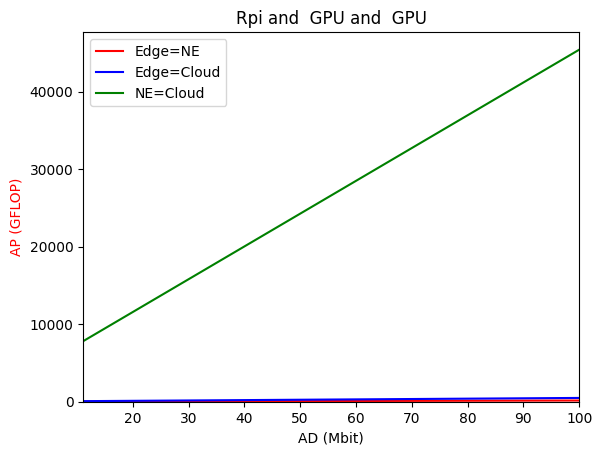

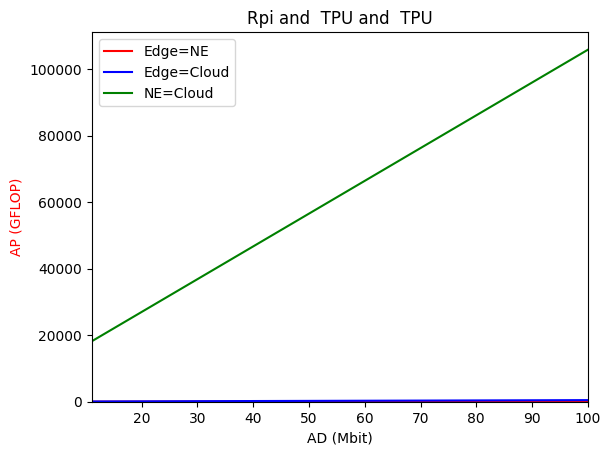

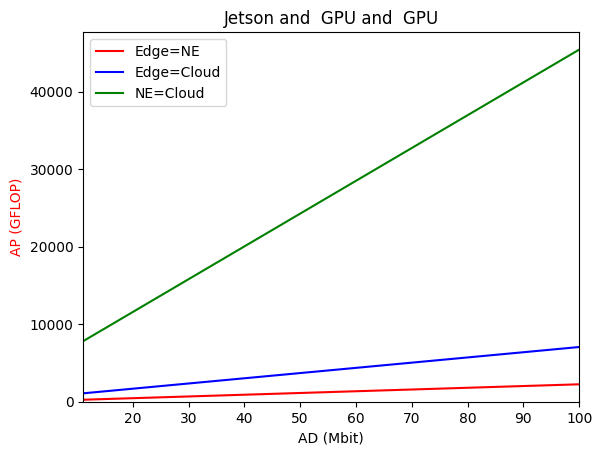

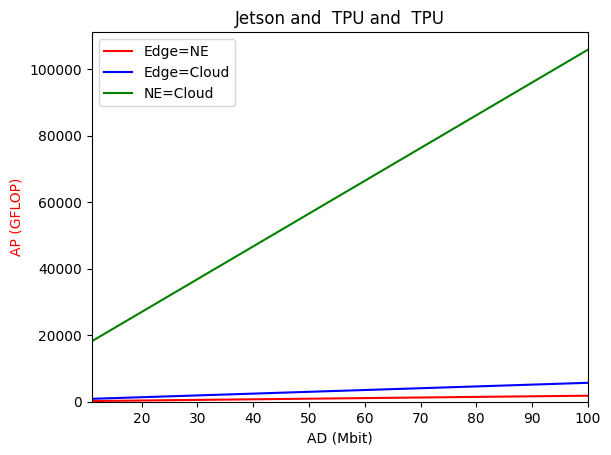

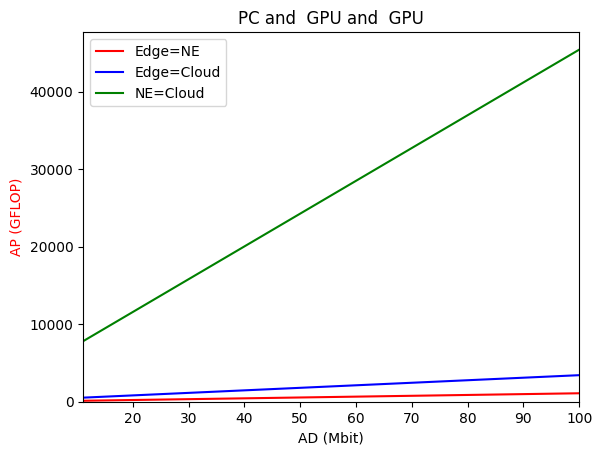

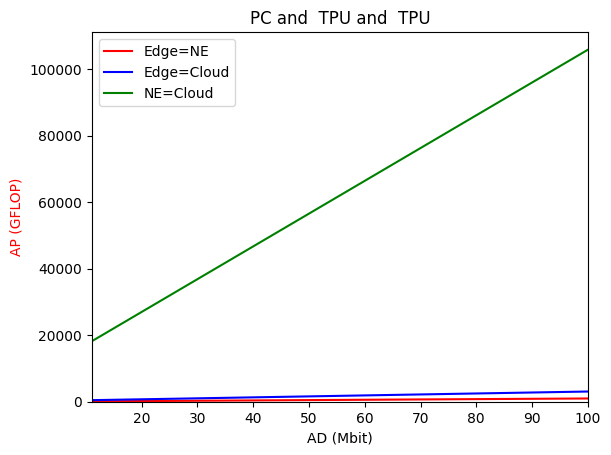

In [ ]:
def plot_cost_AP_vs_AI(self, AI_Values):

    alpha_Edge_equal_NE = []
    alpha_Edge_equal_Cloud = []
    alpha_NE_equal_Cloud = []
    AP_Edge_equal_NE = []
    AP_Edge_equal_Cloud = []
    AP_NE_equal_Cloud = []
    global cost_Edge_equal_NE
    global cost_Edge_equal_Cloud
    global cost_NE_equal_Cloud

    for AI in AI_Values:
        AP = self.find_satisfying_AP_cost_AP_Edge_NE(AI)
        cost_Edge_equal_NE.append(self.compute_cost_Edge(AP))
        alpha_Edge_equal_NE.append(AP/AI)
        AP_Edge_equal_NE.append(AP)

        AP = self.find_satisfying_AP_cost_AP_Edge_Cloud(AI)
        AP_Edge_equal_Cloud.append(AP)
        alpha_Edge_equal_Cloud.append(AP/AI)
        cost_Edge_equal_Cloud.append(self.compute_cost_Edge(AP))

        AP = self.find_satisfying_AP_cost_AP_NE_Cloud(AI)
        AP_NE_equal_Cloud.append(AP)
        alpha_NE_equal_Cloud.append(AP/AI)
        cost_NE_equal_Cloud.append(self.compute_cost_Cloud(AP, AI))

    # print(latency_Edge_equal_NE)
    # print(latency_Edge_equal_Cloud)
    # print(latency_NE_equal_Cloud)

    # print(AP_Edge_equal_NE)
    # print(AP_Edge_equal_Cloud)
    # print(AP_NE_equal_Cloud)

    fig, ax1 = plt.subplots()
    # ax2 = ax1.twinx()

    # ax1.plot(alpha_values_latency, k_values_latency, 'k-', label = 'k')

    # ax2.plot(alpha_values, UtilizationEdge, 'r-')

    ax1.plot(AI_Values, AP_Edge_equal_NE, 'r-', label = 'Edge=NE')
    ax1.plot(AI_Values, AP_Edge_equal_Cloud, 'b-', label = 'Edge=Cloud')
    ax1.plot(AI_Values, AP_NE_equal_Cloud, 'g-', label = 'NE=Cloud')

    ax1.set_xlabel('AD (Mbit)')
    ax1.set_ylabel('AP (GFLOP)', color='r')

    # Display legend
    lines, labels = ax1.get_legend_handles_labels()
    ax1.legend(lines, labels, loc='upper left')

    plt.xlim(left=AI_Values[0])
    plt.xlim(right=AI_Values[-1])
    plt.ylim(bottom=0)

    plt.title(Device[self.edge] + ' and ' + NE[self.ne] + ' and ' + Cloud[self.cloud])
    # Save the first plot
    # plt.savefig(device + '_' + NE + Cloud + '_latency.png')
    plt.show()

cost_Edge_equal_NE = []
cost_Edge_equal_Cloud = []
cost_NE_equal_Cloud = []

AD_Values = np.linspace(0, 100, 10)[1:]
for inf in system:
    plot_cost_AP_vs_AI(inf,AD_Values)

# Plot latency and cost boundaries

In [ ]:
# AD_Values = np.linspace(0, 10, 10)[1:]
for inf in system:
    AP_latency_Edge_equal_NE = []
    AP_latency_Edge_equal_Cloud = []
    AP_latency_NE_equal_Cloud = []

    AP_cost_Edge_equal_NE = []
    AP_cost_Edge_equal_Cloud = []
    AP_cost_NE_equal_Cloud = []

    for AI in AD_Values:
        AP = inf.find_satisfying_AP_latency_AP_Edge_NE(AI)
        AP_latency_Edge_equal_NE.append(AP)

        AP = inf.find_satisfying_AP_latency_AP_Edge_Cloud(AI)
        AP_latency_Edge_equal_Cloud.append(AP)

        AP = inf.find_satisfying_AP_latency_AP_NE_Cloud(AI)
        AP_latency_NE_equal_Cloud.append(AP)

        AP = inf.find_satisfying_AP_cost_AP_Edge_NE(AI)
        AP_cost_Edge_equal_NE.append(AP)

        AP = inf.find_satisfying_AP_cost_AP_Edge_Cloud(AI)
        AP_cost_Edge_equal_Cloud.append(AP)


        AP = inf.find_satisfying_AP_cost_AP_NE_Cloud(AI)
        AP_cost_NE_equal_Cloud.append(AP)

    # print(AP_cost_NE_equal_Cloud)

    fig, ax1 = plt.subplots()

    ax1.plot(AD_Values, AP_latency_Edge_equal_NE, 'r-', label = 'Latency Edge=NE')
    ax1.plot(AD_Values, AP_latency_Edge_equal_Cloud, 'b-', label = 'Latency Edge=Cloud')
    # ax1.plot(AD_Values, AP_latency_NE_equal_Cloud, 'g-', label = 'Latency NE=Cloud')

    ax1.plot(AD_Values, AP_cost_Edge_equal_NE, 'r--', label = 'Cost Edge=NE')
    ax1.plot(AD_Values, AP_cost_Edge_equal_Cloud, 'b--', label = 'Cost Edge=Cloud')
    # ax1.plot(AD_Values, AP_cost_NE_equal_Cloud, 'g--', label = 'Cost NE=Cloud')

    ax1.set_xlabel('AD (Mbit)')
    ax1.set_ylabel('AP (GFLOP)', color='r')

    # Display legend
    lines, labels = ax1.get_legend_handles_labels()
    ax1.legend(lines, labels, loc='upper left')

    plt.xlim(left=AD_Values[0])
    plt.xlim(right=AD_Values[-1])
    plt.ylim(bottom=0)

    plt.title(Device[inf.edge] + ' and ' + NE[inf.ne] + ' and ' + Cloud[inf.cloud])
    # Save the first plot
    # plt.savefig(device + '_' + NE + Cloud + '_latency.png')
    plt.show()

# Effect of changing Network Transmission cost

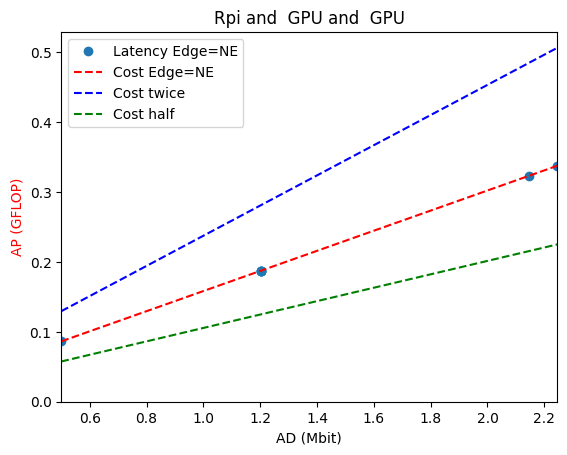

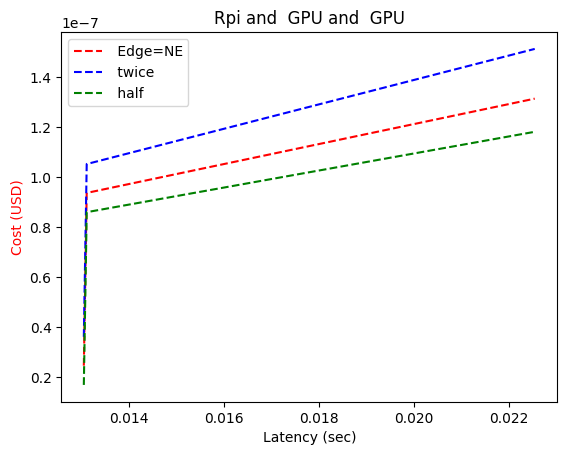

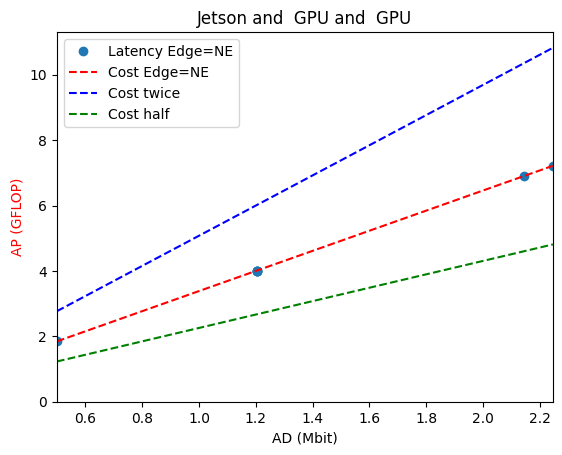

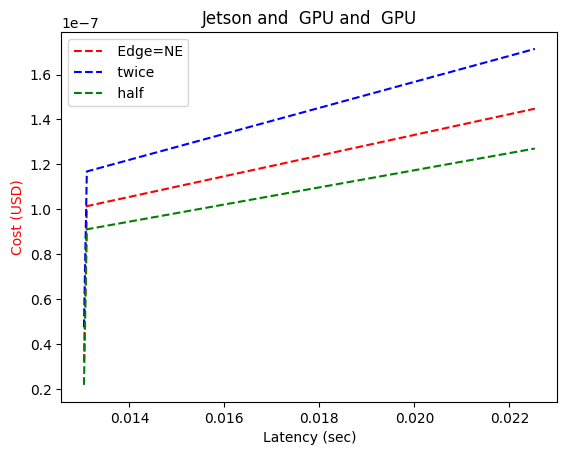

In [16]:
# AD_Values = np.linspace(0, 10, 10)[1:]

fac = 1.5
for inf in system:
    AP_latency_Edge_equal_NE = []
    AP_latency_Edge_equal_Cloud = []
    AP_latency_NE_equal_Cloud = []

    AP_cost_Edge_equal_NE = []
    AP_cost_Edge_equal_Cloud = []
    AP_cost_NE_equal_Cloud = []

    AP_cost_Edge_equal_NE_twice = []
    AP_cost_Edge_equal_NE_half = []

    cost_Edge_equal_NE = []
    cost_Edge_equal_NE_twice = []
    cost_Edge_equal_NE_half = []

    latency_Edge_equal_NE = []
    latency_Edge_equal_NE_twice = []
    latency_Edge_equal_NE_half = []

    for AI in AD_Values:
        AP = inf.find_satisfying_AP_latency_AP_Edge_NE(AI)
        AP_latency_Edge_equal_NE.append(AP)

        # AP = inf.find_satisfying_AP_latency_AP_Edge_Cloud(AI)
        # AP_latency_Edge_equal_Cloud.append(AP)

        # AP = inf.find_satisfying_AP_latency_AP_NE_Cloud(AI)
        # AP_latency_NE_equal_Cloud.append(AP)

        AP = inf.find_satisfying_AP_cost_AP_Edge_NE(AI)
        AP_cost_Edge_equal_NE.append(AP)

        # AP = inf.find_satisfying_AP_cost_AP_Edge_Cloud(AI)
        # AP_cost_Edge_equal_Cloud.append(AP)


        # AP = inf.find_satisfying_AP_cost_AP_NE_Cloud(AI)
        # AP_cost_NE_equal_Cloud.append(AP)
        inf.compute_model_latency()
        cost_Edge_equal_NE = inf.NE_cost
        latency_Edge_equal_NE = inf.NE_latency

        inf.NTrCEtoNE = fac*inf.NTrCEtoNE
        AP = inf.find_satisfying_AP_cost_AP_Edge_NE(AI)
        AP_cost_Edge_equal_NE_twice.append(AP)

        inf.compute_model_latency()
        cost_Edge_equal_NE_twice = inf.NE_cost
        latency_Edge_equal_NE_twice = inf.NE_latency
        inf.NTrCEtoNE = inf.NTrCEtoNE/fac

        inf.NTrCEtoNE = inf.NTrCEtoNE/fac
        AP = inf.find_satisfying_AP_cost_AP_Edge_NE(AI)
        AP_cost_Edge_equal_NE_half.append(AP)
        inf.compute_model_latency()
        cost_Edge_equal_NE_half = inf.NE_cost
        latency_Edge_equal_NE_half = inf.NE_latency
        inf.NTrCEtoNE = inf.NTrCEtoNE*fac

    fig, ax1 = plt.subplots()

    ax1.plot(AD_Values, AP_latency_Edge_equal_NE, 'o', label = 'Latency Edge=NE')
    # ax1.plot(AD_Values, AP_latency_Edge_equal_Cloud, 'b-', label = 'Latency Edge=Cloud')
    # ax1.plot(AD_Values, AP_latency_NE_equal_Cloud, 'g-', label = 'Latency NE=Cloud')

    ax1.plot(AD_Values, AP_cost_Edge_equal_NE, 'r--', label = 'Cost Edge=NE')
    ax1.plot(AD_Values, AP_cost_Edge_equal_NE_twice, 'b--', label = 'Cost twice')
    ax1.plot(AD_Values, AP_cost_Edge_equal_NE_half, 'g--', label = 'Cost half')

    ax1.set_xlabel('AD (Mbit)')
    ax1.set_ylabel('AP (GFLOP)')

    # Display legend
    lines, labels = ax1.get_legend_handles_labels()
    ax1.legend(lines, labels, loc='upper left')

    plt.xlim(left=AD_Values[0])
    plt.xlim(right=AD_Values[-1])
    plt.ylim(bottom=0)

    plt.title(Device[inf.edge] + ' and ' + NE[inf.ne] + ' and ' + Cloud[inf.cloud])
    # Save the first plot
    # plt.savefig(device + '_' + NE + Cloud + '_latency.png')
    plt.show()

    fig, ax1 = plt.subplots()

    ax1.plot(latency_Edge_equal_NE, cost_Edge_equal_NE, 'r--', label = ' Edge=NE')
    ax1.plot(latency_Edge_equal_NE_twice, cost_Edge_equal_NE_twice, 'b--', label = ' twice')
    ax1.plot(latency_Edge_equal_NE_half, cost_Edge_equal_NE_half, 'g--', label = ' half')

    # print(latency_Edge_equal_NE_twice)

    ax1.set_xlabel('Latency (sec)')
    ax1.set_ylabel('Cost (USD)')

    # Display legend
    lines, labels = ax1.get_legend_handles_labels()
    ax1.legend(lines, labels, loc='upper left')

    # plt.xlim(left=AD_Values[0])
    # plt.xlim(right=AD_Values[-1])
    # plt.ylim(bottom=0)

    plt.title(Device[inf.edge] + ' and ' + NE[inf.ne] + ' and ' + Cloud[inf.cloud])
    # Save the first plot
    # plt.savefig(device + '_' + NE + Cloud + '_latency.png')
    plt.show()

Fit models

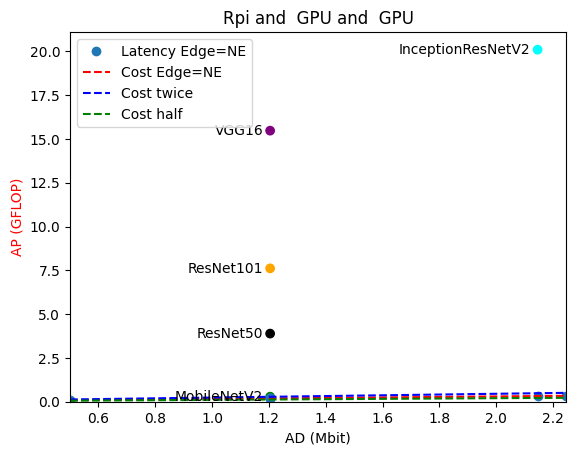

[0.013043394658108975, 0.01305782489375, 0.013072745628108975, 0.013104244787596154, 0.022536768518621797]


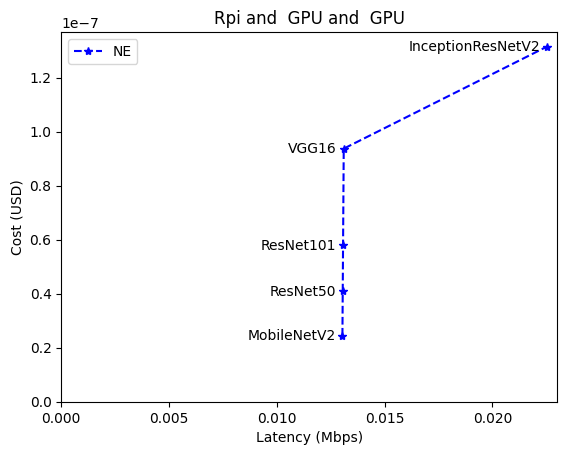

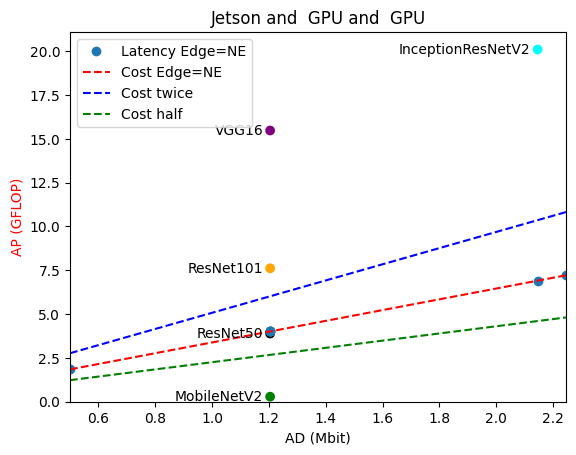

[0.013043394658108975, 0.01305782489375, 0.013072745628108975, 0.013104244787596154, 0.022536768518621797]


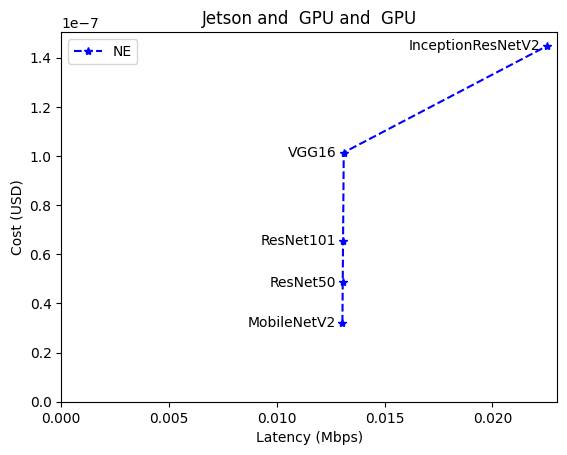

In [ ]:
# AD_Values = np.linspace(0, 10, 10)[1:]
fac = 1.5
for inf in system:
    AP_latency_Edge_equal_NE = []
    AP_latency_Edge_equal_Cloud = []
    AP_latency_NE_equal_Cloud = []

    AP_cost_Edge_equal_NE = []
    AP_cost_Edge_equal_Cloud = []
    AP_cost_NE_equal_Cloud = []

    AP_cost_Edge_equal_NE_twice = []
    AP_cost_Edge_equal_NE_half = []

    for AI in AD_Values:
        AP = inf.find_satisfying_AP_latency_AP_Edge_NE(AI)
        AP_latency_Edge_equal_NE.append(AP)

        AP = inf.find_satisfying_AP_latency_AP_Edge_Cloud(AI)
        AP_latency_Edge_equal_Cloud.append(AP)

        AP = inf.find_satisfying_AP_latency_AP_NE_Cloud(AI)
        AP_latency_NE_equal_Cloud.append(AP)

        AP = inf.find_satisfying_AP_cost_AP_Edge_NE(AI)
        AP_cost_Edge_equal_NE.append(AP)

        AP = inf.find_satisfying_AP_cost_AP_Edge_Cloud(AI)
        AP_cost_Edge_equal_Cloud.append(AP)


        AP = inf.find_satisfying_AP_cost_AP_NE_Cloud(AI)
        AP_cost_NE_equal_Cloud.append(AP)

        # print(inf.NTrCEtoNE)
        inf.NTrCEtoNE = fac*inf.NTrCEtoNE
        AP = inf.find_satisfying_AP_cost_AP_Edge_NE(AI)
        AP_cost_Edge_equal_NE_twice.append(AP)
        inf.NTrCEtoNE = inf.NTrCEtoNE/fac
        # print(inf.NTrCEtoNE)
        inf.NTrCEtoNE = inf.NTrCEtoNE/fac
        AP = inf.find_satisfying_AP_cost_AP_Edge_NE(AI)
        AP_cost_Edge_equal_NE_half.append(AP)
        inf.NTrCEtoNE = inf.NTrCEtoNE*fac
        # print(inf.NTrCEtoNE)
    # print(AP_cost_Edge_equal_NE_half)
    # print(AP_cost_Edge_equal_NE)
    # print(AP_cost_Edge_equal_NE_twice)


    fig, ax1 = plt.subplots()

    ax1.plot(AD_Values, AP_latency_Edge_equal_NE, 'o', label = 'Latency Edge=NE')
    # ax1.plot(AD_Values, AP_latency_Edge_equal_Cloud, 'b-', label = 'Latency Edge=Cloud')
    # ax1.plot(AD_Values, AP_latency_NE_equal_Cloud, 'g-', label = 'Latency NE=Cloud')

    ax1.plot(AD_Values, AP_cost_Edge_equal_NE, 'r--', label = 'Cost Edge=NE')
    ax1.plot(AD_Values, AP_cost_Edge_equal_NE_twice, 'b--', label = 'Cost twice')
    ax1.plot(AD_Values, AP_cost_Edge_equal_NE_half, 'g--', label = 'Cost half')

    ax1.set_xlabel('AD (Mbit)')
    ax1.set_ylabel('AP (GFLOP)', color='r')

    # Display legend
    lines, labels = ax1.get_legend_handles_labels()
    ax1.legend(lines, labels, loc='upper left')

    ax1.scatter(AD_models,AP_models, c=colors)
    for i, label in enumerate(labels_model):
        plt.annotate(label, (AD_models[i], AP_models[i]), xytext=(-5, 5), textcoords='offset points', ha='right', va='top')

    plt.xlim(left=AD_Values[0])
    plt.xlim(right=AD_Values[-1])
    plt.ylim(bottom=0)

    plt.title(Device[inf.edge] + ' and ' + NE[inf.ne] + ' and ' + Cloud[inf.cloud])
    # Save the first plot
    # plt.savefig(device + '_' + NE + Cloud + '_latency.png')
    plt.show()

    fig, ax1 = plt.subplots()

    # ax1.plot(inf.edge_latency, inf.edge_cost, 'r--', marker = 'o', label = 'Edge')
    ax1.plot(inf.NE_latency, inf.NE_cost, 'b--', marker = '*', label = 'NE')

    print(inf.NE_latency)

    # ax1.scatter(inf.edge_latency,inf.edge_cost, c=colors)
    # ax1.scatter(inf.NE_latency,inf.NE_cost, c=colors)
    for i, label in enumerate(labels_model):
        # plt.annotate(label, (inf.edge_latency[i], inf.edge_cost[i]), xytext=(10, 5), textcoords='offset points', ha='left', va='top')
        plt.annotate(label, (inf.NE_latency[i], inf.NE_cost[i]), xytext=(-5, 5), textcoords='offset points', ha='right', va='top')

    ax1.set_xlabel('Latency (Mbps)')
    ax1.set_ylabel('Cost (USD)')

    # Display legend
    lines, labels = ax1.get_legend_handles_labels()
    ax1.legend(lines, labels, loc='upper left')


    plt.xlim(left=0)
    # plt.xlim(right=AD_Values[-1])
    plt.ylim(bottom=0)

    plt.title(Device[inf.edge] + ' and ' + NE[inf.ne] + ' and ' + Cloud[inf.cloud])
    # Save the first plot
    # plt.savefig(device + '_' + NE + Cloud + '_latency.png')
    plt.show()

# Effect of changing bandwidth

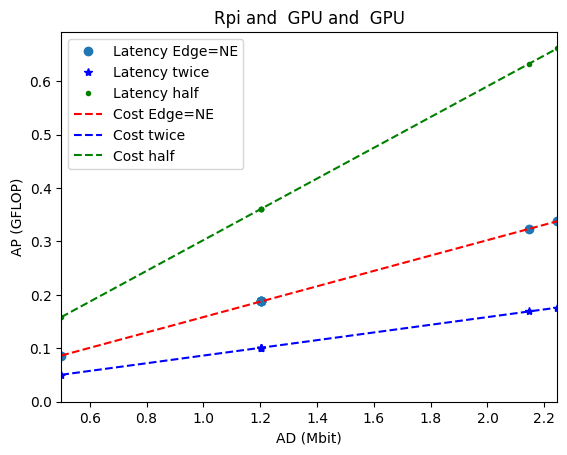

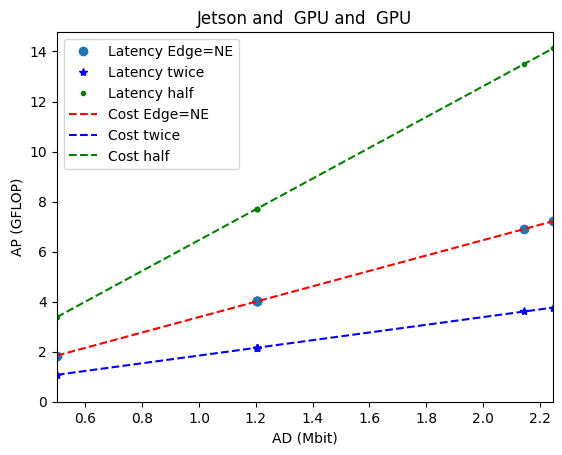

In [ ]:
# AD_Values = np.linspace(0, 10, 10)[1:]
fac = 1.5
factor = 2

for inf in system:
    AP_latency_Edge_equal_NE = []
    AP_latency_Edge_equal_Cloud = []
    AP_latency_NE_equal_Cloud = []

    AP_cost_Edge_equal_NE = []
    AP_cost_Edge_equal_Cloud = []
    AP_cost_NE_equal_Cloud = []

    AP_latency_Edge_equal_NE_twice = []
    AP_latency_Edge_equal_NE_half = []

    AP_cost_Edge_equal_NE_twice = []
    AP_cost_Edge_equal_NE_half = []

    for AI in AD_Values:
        AP = inf.find_satisfying_AP_latency_AP_Edge_NE(AI)
        AP_latency_Edge_equal_NE.append(AP)

        AP = inf.find_satisfying_AP_latency_AP_Edge_Cloud(AI)
        AP_latency_Edge_equal_Cloud.append(AP)

        AP = inf.find_satisfying_AP_latency_AP_NE_Cloud(AI)
        AP_latency_NE_equal_Cloud.append(AP)

        AP = inf.find_satisfying_AP_cost_AP_Edge_NE(AI)
        AP_cost_Edge_equal_NE.append(AP)

        AP = inf.find_satisfying_AP_cost_AP_Edge_Cloud(AI)
        AP_cost_Edge_equal_Cloud.append(AP)


        AP = inf.find_satisfying_AP_cost_AP_NE_Cloud(AI)
        AP_cost_NE_equal_Cloud.append(AP)

        inf.EetoNE = factor*inf.EetoNE
        AP = inf.find_satisfying_AP_cost_AP_Edge_NE(AI)
        AP_cost_Edge_equal_NE_twice.append(AP)
        AP = inf.find_satisfying_AP_latency_AP_Edge_NE(AI)
        AP_latency_Edge_equal_NE_twice.append(AP)
        inf.EetoNE = inf.EetoNE/factor

        inf.EetoNE = inf.EetoNE/factor
        AP = inf.find_satisfying_AP_cost_AP_Edge_NE(AI)
        AP_cost_Edge_equal_NE_half.append(AP)
        AP = inf.find_satisfying_AP_latency_AP_Edge_NE(AI)
        AP_latency_Edge_equal_NE_half.append(AP)
        inf.EetoNE = inf.EetoNE*factor

    # print(AP_cost_Edge_equal_NE_half)
    # print(AP_cost_Edge_equal_NE)
    # print(AP_cost_Edge_equal_NE_twice)


    fig, ax1 = plt.subplots()

    ax1.plot(AD_Values, AP_latency_Edge_equal_NE, 'o', label = 'Latency Edge=NE')
    ax1.plot(AD_Values, AP_latency_Edge_equal_NE_twice, 'b*', label = 'Latency twice')
    ax1.plot(AD_Values, AP_latency_Edge_equal_NE_half, 'g.', label = 'Latency half')

    ax1.plot(AD_Values, AP_cost_Edge_equal_NE, 'r--', label = 'Cost Edge=NE')
    ax1.plot(AD_Values, AP_cost_Edge_equal_NE_twice, 'b--', label = 'Cost twice')
    ax1.plot(AD_Values, AP_cost_Edge_equal_NE_half, 'g--', label = 'Cost half')

    ax1.set_xlabel('AD (Mbit)')
    ax1.set_ylabel('AP (GFLOP)')

    # Display legend
    lines, labels = ax1.get_legend_handles_labels()
    ax1.legend(lines, labels, loc='upper left')

    plt.xlim(left=AD_Values[0])
    plt.xlim(right=AD_Values[-1])
    plt.ylim(bottom=0)

    plt.title(Device[inf.edge] + ' and ' + NE[inf.ne] + ' and ' + Cloud[inf.cloud])
    # Save the first plot
    # plt.savefig(device + '_' + NE + Cloud + '_latency.png')
    plt.show()

Fit models

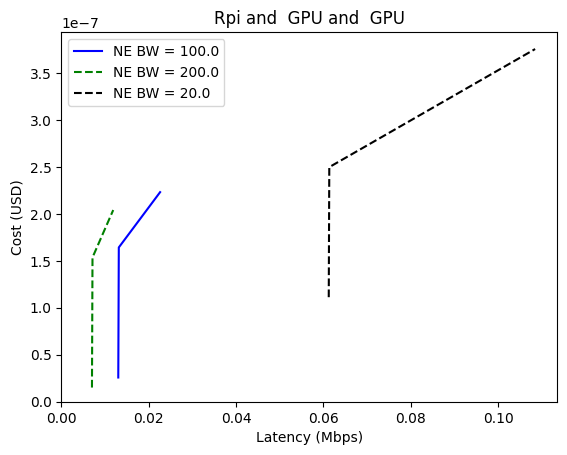

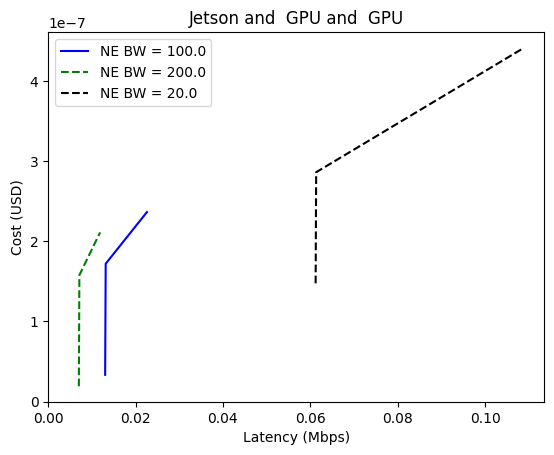

In [ ]:
# AD_Values = np.linspace(0, 10, 10)[1:]
fac = 1.5
# factor = 20
factor = 5
for inf in system:
    AP_latency_Edge_equal_NE = []
    AP_latency_Edge_equal_Cloud = []
    AP_latency_NE_equal_Cloud = []

    AP_cost_Edge_equal_NE = []
    AP_cost_Edge_equal_Cloud = []
    AP_cost_NE_equal_Cloud = []

    AP_latency_Edge_equal_NE_twice = []
    AP_latency_Edge_equal_NE_half = []

    AP_cost_Edge_equal_NE_twice = []
    AP_cost_Edge_equal_NE_half = []

    latency_NE_twice = []
    latency_NE_half = []

    cost_NE_twice = []
    cost_NE_half = []


    for AI in AD_Values:
        AP = inf.find_satisfying_AP_latency_AP_Edge_NE(AI)
        AP_latency_Edge_equal_NE.append(AP)

        AP = inf.find_satisfying_AP_latency_AP_Edge_Cloud(AI)
        AP_latency_Edge_equal_Cloud.append(AP)

        AP = inf.find_satisfying_AP_latency_AP_NE_Cloud(AI)
        AP_latency_NE_equal_Cloud.append(AP)

        AP = inf.find_satisfying_AP_cost_AP_Edge_NE(AI)
        AP_cost_Edge_equal_NE.append(AP)

        AP = inf.find_satisfying_AP_cost_AP_Edge_Cloud(AI)
        AP_cost_Edge_equal_Cloud.append(AP)


        AP = inf.find_satisfying_AP_cost_AP_NE_Cloud(AI)
        AP_cost_NE_equal_Cloud.append(AP)

        inf.EetoNE = 2*inf.EetoNE
        AP = inf.find_satisfying_AP_cost_AP_Edge_NE(AI)
        AP_cost_Edge_equal_NE_twice.append(AP)
        AP = inf.find_satisfying_AP_latency_AP_Edge_NE(AI)
        AP_latency_Edge_equal_NE_twice.append(AP)
        inf.EetoNE = inf.EetoNE/2

        inf.EetoNE = inf.EetoNE/factor
        AP = inf.find_satisfying_AP_cost_AP_Edge_NE(AI)
        AP_cost_Edge_equal_NE_half.append(AP)
        AP = inf.find_satisfying_AP_latency_AP_Edge_NE(AI)
        AP_latency_Edge_equal_NE_half.append(AP)
        inf.EetoNE = inf.EetoNE*factor

    inf.EetoNE = 2*inf.EetoNE
    inf.compute_model_latency()
    latency_NE_twice = inf.NE_latency
    cost_NE_twice = inf.NE_cost
    inf.EetoNE = inf.EetoNE/2

    inf.EetoNE = inf.EetoNE/factor
    inf.compute_model_latency()
    latency_NE_half = inf.NE_latency
    cost_NE_half = inf.NE_cost
    inf.EetoNE = inf.EetoNE*factor
    inf.compute_model_latency()

    fig, ax1 = plt.subplots()

    # ax1.plot(inf.edge_latency, inf.edge_cost, 'r--', marker = 'o', label = 'Edge ')
    ax1.plot(inf.NE_latency, inf.NE_cost, 'b-', label = 'NE BW = ' + str(inf.EetoNE))
    ax1.plot(latency_NE_twice, cost_NE_twice, 'g--', label = 'NE BW = ' + str(2*inf.EetoNE))
    ax1.plot(latency_NE_half, cost_NE_half, 'k--', label = 'NE BW = ' + str(inf.EetoNE/factor))

    print()
    ax1.set_xlabel('Latency (Mbps)')
    ax1.set_ylabel('Cost (USD)')

    # Display legend
    lines, labels = ax1.get_legend_handles_labels()
    ax1.legend(lines, labels, loc='upper left')

    # ax1.scatter(AD_models,AP_models, c=colors)
    # for i, label in enumerate(labels_model):
    #     plt.annotate(label, (inf.edge_latency[i], inf.edge_cost[i]), xytext=(-5, 5), textcoords='offset points', ha='right', va='top')

    plt.xlim(left=0)
    # plt.xlim(right=AD_Values[-1])
    plt.ylim(bottom=0)

    plt.title(Device[inf.edge] + ' and ' + NE[inf.ne])
    # Save the first plot
    # plt.savefig(device + '_' + NE + Cloud + '_latency.png')
    plt.show()


    # fig, ax1 = plt.subplots()

    # ax1.plot(AD_Values, AP_latency_Edge_equal_NE, 'r.', label = 'Latency BW = ' + str(inf.EetoNE))
    # ax1.plot(AD_Values, AP_latency_Edge_equal_NE_twice, 'b*', label = 'Latency BW = ' + str(2*inf.EetoNE))
    # ax1.plot(AD_Values, AP_latency_Edge_equal_NE_half, 'g8', label = 'Latency BW = ' + str(inf.EetoNE/factor))

    # ax1.plot(AD_Values, AP_cost_Edge_equal_NE, 'r--', label = 'Cost BW = ' + str(inf.EetoNE))
    # ax1.plot(AD_Values, AP_cost_Edge_equal_NE_twice, 'b--', label = 'Cost BW = ' + str(2*inf.EetoNE))
    # ax1.plot(AD_Values, AP_cost_Edge_equal_NE_half, 'g--', label = 'Cost BW = ' + str(inf.EetoNE/factor))

    # ax1.set_xlabel('AD (Mbit)')
    # ax1.set_ylabel('AP (GFLOP)')

    # # Display legend
    # lines, labels = ax1.get_legend_handles_labels()
    # ax1.legend(lines, labels, loc='upper left')

    # ax1.scatter(AD_models,AP_models, c=colors)
    # for i, label in enumerate(labels_model):
    #     plt.annotate(label, (AD_models[i], AP_models[i]), xytext=(-5, 5), textcoords='offset points', ha='right', va='top')

    # plt.xlim(left=AD_Values[0])
    # plt.xlim(right=AD_Values[-1])
    # plt.ylim(bottom=0)

    # plt.title(Device[inf.edge] + ' and ' + NE[inf.ne] + ' and ' + Cloud[inf.cloud])
    # # Save the first plot
    # # plt.savefig(device + '_' + NE + Cloud + '_latency.png')
    # plt.show()

# Fit models latency cost trade off

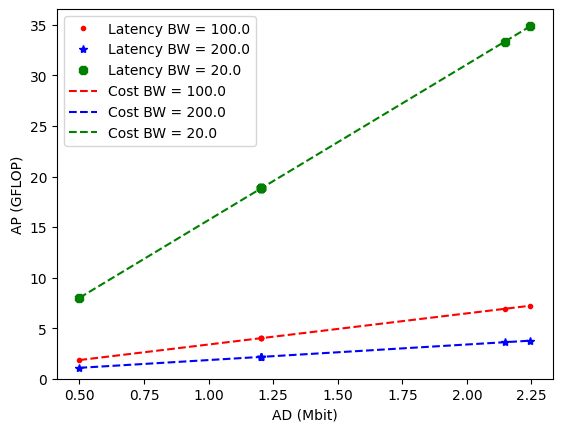

In [ ]:
# AD_Values = np.linspace(0, 10, 10)[1:]
fac = 1.5
# factor = 20
factor = 5
for inf in system:
    AP_latency_Edge_equal_NE = []
    AP_latency_Edge_equal_Cloud = []
    AP_latency_NE_equal_Cloud = []

    AP_cost_Edge_equal_NE = []
    AP_cost_Edge_equal_Cloud = []
    AP_cost_NE_equal_Cloud = []

    AP_latency_Edge_equal_NE_twice = []
    AP_latency_Edge_equal_NE_half = []

    AP_cost_Edge_equal_NE_twice = []
    AP_cost_Edge_equal_NE_half = []

    for AI in AD_Values:
        AP = inf.find_satisfying_AP_latency_AP_Edge_NE(AI)
        AP_latency_Edge_equal_NE.append(AP)

        AP = inf.find_satisfying_AP_latency_AP_Edge_Cloud(AI)
        AP_latency_Edge_equal_Cloud.append(AP)

        AP = inf.find_satisfying_AP_latency_AP_NE_Cloud(AI)
        AP_latency_NE_equal_Cloud.append(AP)

        AP = inf.find_satisfying_AP_cost_AP_Edge_NE(AI)
        AP_cost_Edge_equal_NE.append(AP)

        AP = inf.find_satisfying_AP_cost_AP_Edge_Cloud(AI)
        AP_cost_Edge_equal_Cloud.append(AP)


        AP = inf.find_satisfying_AP_cost_AP_NE_Cloud(AI)
        AP_cost_NE_equal_Cloud.append(AP)

        # inf.NTrCEtoNE = fac*inf.NTrCEtoNE
        # AP = inf.find_satisfying_AP_cost_AP_Edge_NE(AI)
        # AP_cost_Edge_equal_NE_twice.append(AP)
        # inf.NTrCEtoNE = inf.NTrCEtoNE/fac

        # inf.NTrCEtoNE = inf.NTrCEtoNE/fac
        # AP = inf.find_satisfying_AP_cost_AP_Edge_NE(AI)
        # AP_cost_Edge_equal_NE_half.append(AP)
        # inf.NTrCEtoNE = inf.NTrCEtoNE*fac

        inf.EetoNE = 2*inf.EetoNE
        AP = inf.find_satisfying_AP_cost_AP_Edge_NE(AI)
        AP_cost_Edge_equal_NE_twice.append(AP)
        AP = inf.find_satisfying_AP_latency_AP_Edge_NE(AI)
        AP_latency_Edge_equal_NE_twice.append(AP)
        inf.EetoNE = inf.EetoNE/2

        inf.EetoNE = inf.EetoNE/factor
        AP = inf.find_satisfying_AP_cost_AP_Edge_NE(AI)
        AP_cost_Edge_equal_NE_half.append(AP)
        AP = inf.find_satisfying_AP_latency_AP_Edge_NE(AI)
        AP_latency_Edge_equal_NE_half.append(AP)
        inf.EetoNE = inf.EetoNE*factor


fig, ax1 = plt.subplots()

ax1.plot(AD_Values, AP_latency_Edge_equal_NE, 'r.', label = 'Latency BW = ' + str(inf.EetoNE))
ax1.plot(AD_Values, AP_latency_Edge_equal_NE_twice, 'b*', label = 'Latency BW = ' + str(2*inf.EetoNE))
ax1.plot(AD_Values, AP_latency_Edge_equal_NE_half, 'g8', label = 'Latency BW = ' + str(inf.EetoNE/factor))

ax1.plot(AD_Values, AP_cost_Edge_equal_NE, 'r--', label = 'Cost BW = ' + str(inf.EetoNE))
ax1.plot(AD_Values, AP_cost_Edge_equal_NE_twice, 'b--', label = 'Cost BW = ' + str(2*inf.EetoNE))
ax1.plot(AD_Values, AP_cost_Edge_equal_NE_half, 'g--', label = 'Cost BW = ' + str(inf.EetoNE/factor))

ax1.set_xlabel('AD (Mbit)')
ax1.set_ylabel('AP (GFLOP)')

# Display legend
lines, labels = ax1.get_legend_handles_labels()
ax1.legend(lines, labels, loc='upper left')

# plt.xlim(left=0)
# plt.xlim(right=AD_Values[-1])
plt.ylim(bottom=0)

# plt.title(Device[inf.edge] + ' and ' + NE[inf.ne] + ' and ' + Cloud[inf.cloud])
# Save the first plot
# plt.savefig(device + '_' + NE + Cloud + '_latency.png')
plt.show()

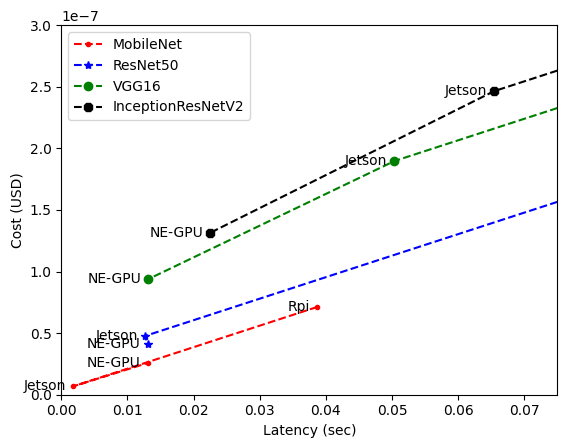

In [ ]:

fig, ax1 = plt.subplots()

# ax1.plot(MobileNet_latency, MobileNet_cost, 'r-', label = 'MobileNet')
# ax1.plot(ResNet50_latency, ResNet50_cost, 'b-', label = 'ResNet50')
# ax1.plot(VGG16_latency, VGG16_cost, 'g-', label = 'VGG16')
# ax1.plot(InceptionResNetV2_latency, InceptionResNetV2_cost, 'k-', label = 'InceptionResNetV2')

# # Display legend
lines, labels = ax1.get_legend_handles_labels()
ax1.legend(lines, labels, loc='upper left')

# ax1.scatter(Rpi_latency_models,Rpi_cost_models, c=colors)
# ax1.scatter(Jetson_latency_models,Jetson_cost_models, c=colors)
# ax1.scatter(PC_latency_models,PC_cost_models, c=colors)
# ax1.scatter(GPU_NE_latency_models,GPU_NE_cost_models)

# for i, label in enumerate(labels_model):
#     plt.annotate(label, (Rpi_latency_models[i], Rpi_cost_models[i]), xytext=(-5, 5), textcoords='offset points', ha='right', va='top')
#     plt.annotate(label, (Jetson_latency_models[i], Jetson_cost_models[i]), xytext=(-5, 5), textcoords='offset points', ha='right', va='top')
#     plt.annotate(label, (PC_latency_models[i], PC_cost_models[i]), xytext=(-5, 5), textcoords='offset points', ha='right', va='top')
#     plt.annotate(label, (GPU_NE_latency_models[i], GPU_NE_cost_models[i]), xytext=(-5, 5), textcoords='offset points', ha='right', va='top')


# ax1.scatter(MobileNet_latency,MobileNet_cost, label="MobileNet")
# ax1.scatter(ResNet50_latency,ResNet50_cost, label="ResNet50")
# ax1.scatter(VGG16_latency,VGG16_cost,  label="VGG16")
# ax1.scatter(InceptionResNetV2_latency,InceptionResNetV2_cost, label="InceptionResNetV2")

ax1.plot(MobileNet_latency,MobileNet_cost, 'r--', marker = '.', label="MobileNet")
ax1.plot(ResNet50_latency,ResNet50_cost, 'b--',marker = '*', label="ResNet50")
ax1.plot(VGG16_latency,VGG16_cost, 'g--', marker = 'o', label="VGG16")
ax1.plot(InceptionResNetV2_latency,InceptionResNetV2_cost, 'k--', marker = '8', label="InceptionResNetV2")
# # # Display legend
lines, labels = ax1.get_legend_handles_labels()
ax1.legend(lines, labels, loc='upper left')

# ax1.scatter(MobileNet_latency[1:-1],MobileNet_cost[1:-1], c=colors[1:-1])
# ax1.scatter(ResNet50_latency[1:-1],ResNet50_cost[1:-1], c=colors[1:-1])
# ax1.scatter(VGG16_latency[1:-1],VGG16_cost[1:-1], c=colors[1:-1])
# ax1.scatter(InceptionResNetV2_latency[1:-1],InceptionResNetV2_cost[1:-1], c=colors[1:-1])
# labels_model_device = []
# labels_model_device = [x for x in Device]
# labels_model_device.append('NE-GPU')

for i, label in enumerate(labels_model_device):
    plt.annotate(label, (MobileNet_latency[i], MobileNet_cost[i]), xytext=(-5, 5), textcoords='offset points', ha='right', va='top')
    plt.annotate(label, (ResNet50_latency[i], ResNet50_cost[i]), xytext=(-5, 5), textcoords='offset points', ha='right', va='top')
    plt.annotate(label, (VGG16_latency[i], VGG16_cost[i]), xytext=(-5, 5), textcoords='offset points', ha='right', va='top')
    plt.annotate(label, (InceptionResNetV2_latency[i], InceptionResNetV2_cost[i]), xytext=(-5, 5), textcoords='offset points', ha='right', va='top')

# Add labels and title
ax1.set_xlabel('Latency (sec)')
ax1.set_ylabel('Cost (USD)')

plt.xlim(left=0)
plt.xlim(right=0.075)
plt.ylim(bottom=0)
plt.ylim(top=0.3*10 ** -6)
# plt.title(Device[inf.edge] + ' and ' + NE[inf.ne] + ' and ' + Cloud[inf.cloud])
# Save the first plot
# plt.savefig(device + '_' + NE + Cloud + '_latency.png')
plt.show()

# Plot latency and cost boundaries between Edge = NE for different bandwidths

In [ ]:

BW_EetoNE_latency = np.linspace(100, 500, 2)[0:]
for inf in system:
    AP_latency_Edge_equal_NE = []
    AP_latency_Edge_equal_Cloud = []
    AP_latency_NE_equal_Cloud = []

    AP_cost_Edge_equal_NE = []
    AP_cost_Edge_equal_Cloud = []
    AP_cost_NE_equal_Cloud = []
    for bw in BW_EetoNE_latency:
      inf.EetoNE = bw
      inf.EetoC = bw
      if inf.check_condition():
          for AI in AD_Values:
              AP = inf.find_satisfying_AP_latency_AP_Edge_NE(AI)
              AP_latency_Edge_equal_NE.append(AP)

              # AP = inf.find_satisfying_AP_latency_AP_Edge_Cloud(AI)
              # AP_latency_Edge_equal_Cloud.append(AP)

              # AP = inf.find_satisfying_AP_latency_AP_NE_Cloud(AI)
              # AP_latency_NE_equal_Cloud.append(AP)

              AP = inf.find_satisfying_AP_cost_AP_Edge_NE(AI)
              AP_cost_Edge_equal_NE.append(AP)

              # AP = inf.find_satisfying_AP_cost_AP_Edge_Cloud(AI)
              # AP_cost_Edge_equal_Cloud.append(AP)


              # AP = inf.find_satisfying_AP_cost_AP_NE_Cloud(AI)
              # AP_cost_NE_equal_Cloud.append(AP)

    # print(AP_cost_NE_equal_Cloud)

    fig, ax1 = plt.subplots()

    ax1.plot(AD_Values, AP_latency_Edge_equal_NE[0:len(AD_Values)], 'r-', label = 'Latency Edge=NE - ' + str(BW_EetoNE_latency[0]))
    ax1.plot(AD_Values, AP_cost_Edge_equal_NE[0:len(AD_Values)], 'r--', label = 'Cost Edge=NE - ' + str(BW_EetoNE_latency[0]))
    ax1.plot(AD_Values, AP_latency_Edge_equal_NE[len(AD_Values):2*len(AD_Values)], 'b-', label = 'Latency Edge=NE - ' + str(BW_EetoNE_latency[1]))
    ax1.plot(AD_Values, AP_cost_Edge_equal_NE[len(AD_Values):2*len(AD_Values)], 'b--', label = 'Cost Edge=NE - ' + str(BW_EetoNE_latency[1]))
    # ax1.plot(AD_Values, AP_latency_Edge_equal_NE[2*len(AD_Values):3*len(AD_Values)], 'g-', label = 'Latency Edge=NE - ' + str(BW_EetoNE_latency[2]))
    # ax1.plot(AD_Values, AP_cost_Edge_equal_NE[2*len(AD_Values):3*len(AD_Values)], 'g--', label = 'Cost Edge=NE - ' + str(BW_EetoNE_latency[2]))



    ax1.set_xlabel('AD (Mbit)')
    ax1.set_ylabel('AP (GFLOP)')

    # Display legend
    lines, labels = ax1.get_legend_handles_labels()
    ax1.legend(lines, labels, loc='upper left')

    plt.xlim(left=AD_Values[0])
    plt.xlim(right=AD_Values[-1])
    plt.ylim(bottom=0)

    plt.title(Device[inf.edge] + ' and ' + NE[inf.ne] + ' and ' + Cloud[inf.cloud])
    # Save the first plot
    # plt.savefig(device + '_' + NE + Cloud + '_latency.png')
    plt.show()

# Fit models in 3 tiers latency and cost

In [ ]:
for inf in system:
    # inf.EetoNE = 100
    AP_latency_Edge_equal_NE = []
    AP_latency_Edge_equal_Cloud = []
    AP_latency_NE_equal_Cloud = []

    AP_cost_Edge_equal_NE = []
    AP_cost_Edge_equal_Cloud = []
    AP_cost_NE_equal_Cloud = []

    for AI in AD_Values:
        AP = inf.find_satisfying_AP_latency_AP_Edge_NE(AI)
        AP_latency_Edge_equal_NE.append(AP)

        AP = inf.find_satisfying_AP_latency_AP_Edge_Cloud(AI)
        AP_latency_Edge_equal_Cloud.append(AP)

        AP = inf.find_satisfying_AP_latency_AP_NE_Cloud(AI)
        AP_latency_NE_equal_Cloud.append(AP)

        AP = inf.find_satisfying_AP_cost_AP_Edge_NE(AI)
        AP_cost_Edge_equal_NE.append(AP)

        AP = inf.find_satisfying_AP_cost_AP_Edge_Cloud(AI)
        AP_cost_Edge_equal_Cloud.append(AP)


        AP = inf.find_satisfying_AP_cost_AP_NE_Cloud(AI)
        AP_cost_NE_equal_Cloud.append(AP)

    if inf.ne == 1:
        fig, ax1 = plt.subplots()

        ax1.plot(AD_Values, AP_latency_Edge_equal_NE, 'r-', label = 'Latency Edge=NE')
        # ax1.plot(AD_Values, AP_latency_Edge_equal_Cloud, 'g-', label = 'Latency Edge=Cloud')
        # ax1.plot(AD_Values, AP_latency_NE_equal_Cloud, 'g-', label = 'Latency NE=Cloud')

        ax1.plot(AD_Values, AP_cost_Edge_equal_NE, 'b-', label = 'Cost Edge=NE')
        # ax1.plot(AD_Values, AP_cost_Edge_equal_Cloud, 'g*', label = 'Cost Edge=Cloud')
        # ax1.plot(AD_Values, AP_cost_NE_equal_Cloud, 'c-', label = 'Cost NE=Cloud')

        ax1.set_xlabel('AD (Mbit)')
        ax1.set_ylabel('AP (GFLOP)')

        # Display legend
        lines, labels = ax1.get_legend_handles_labels()
        ax1.legend(lines, labels, loc='upper left')

        ax1.scatter(AD_models,AP_models, c=colors)
        for i, label in enumerate(labels_model):
            plt.annotate(label, (AD_models[i], AP_models[i]), xytext=(-5, 5), textcoords='offset points', ha='right', va='top')

        plt.xlim(left=AD_Values[0])
        plt.xlim(right=AD_Values[-1])
        plt.ylim(bottom=0)

        plt.title(Device[inf.edge] + ' and ' + NE[inf.ne])
        # Save the first plot
        plt.savefig(Device[inf.edge] + ' and ' + NE[inf.ne])
        plt.show()


# Fit models between Edge=NE latency and Cost
# For all Edge devices

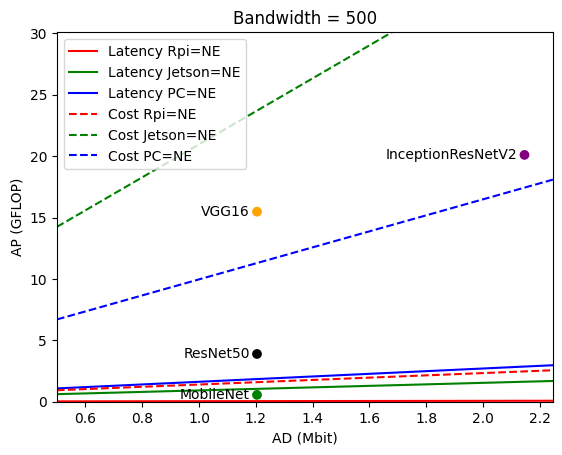

In [ ]:
NTrC = 5.787 * 10 ** -5 # CAD Bell
NTrc = 7.716 * 10 ** -6 # USD AT&T
latency_Edge_equal_NE = []
latency_Edge_equal_Cloud = []
latency_NE_equal_Cloud = []

latency_Rpi = []
latency_Jetson = []
latency_PC = []
latency_NE = []

cost_Rpi = []
cost_Jetson = []
cost_PC = []
cost_NE = []

model_latency = []
model_cost = []

AP_latency_Rpi_equal_NE = []
AP_latency_Jetson_equal_NE = []
AP_latency_PC_equal_NE = []
AP_cost_Rpi_equal_NE = []
AP_cost_Jetson_equal_NE = []
AP_cost_PC_equal_NE = []

for model in Models:
    latency_Rpi.append(model.sum/(Rpi[0]*Utilization_Edge))
    latency_Jetson.append(model.sum/(Jetson[0]*Utilization_Edge))
    latency_PC.append(model.sum/(PC[0]*Utilization_Edge))
    cost_Rpi.append((Rpi[3] * model.sum)/(Rpi[0]*Utilization_Edge))
    cost_Jetson.append((Jetson[3] * model.sum)/(Jetson[0]*Utilization_Edge))
    cost_PC.append((PC[3] * model.sum)/(PC[0]*Utilization_Edge))
    latency_NE.append(inf.compute_latency_NE(model.sum,model.layer_AI[0]))
    cost_NE.append(inf.compute_cost_NE(model.sum,model.layer_AI[0]))
EetoNE = 500
inf = Infrastructure(0,1,1,Utilization_Edge,Utilization_NE,EetoNE,EetoC,EetoC,PDEtoNE,PDEtoC)

for AI in AD_Values:
    AP = inf.find_satisfying_AP_latency_AP_Edge_NE(AI)
    AP_latency_Rpi_equal_NE.append(AP)
    AP = inf.find_satisfying_AP_cost_AP_Edge_NE(AI)
    AP_cost_Rpi_equal_NE.append(AP)

inf = Infrastructure(1,1,1,Utilization_Edge,Utilization_NE,EetoNE,EetoC,EetoC,PDEtoNE,PDEtoC)
for AI in AD_Values:
    AP = inf.find_satisfying_AP_latency_AP_Edge_NE(AI)
    AP_latency_Jetson_equal_NE.append(AP)
    AP = inf.find_satisfying_AP_cost_AP_Edge_NE(AI)
    AP_cost_Jetson_equal_NE.append(AP)

inf = Infrastructure(2,1,1,Utilization_Edge,Utilization_NE,EetoNE,EetoC,EetoC,PDEtoNE,PDEtoC)
for AI in AD_Values:
    AP = inf.find_satisfying_AP_latency_AP_Edge_NE(AI)
    AP_latency_PC_equal_NE.append(AP)
    AP = inf.find_satisfying_AP_cost_AP_Edge_NE(AI)
    AP_cost_PC_equal_NE.append(AP)

fig, ax1 = plt.subplots()

ax1.plot(AD_Values, AP_latency_Rpi_equal_NE, 'r-', label = 'Latency Rpi=NE')
ax1.plot(AD_Values, AP_latency_Jetson_equal_NE, 'g-', label = 'Latency Jetson=NE')
ax1.plot(AD_Values, AP_latency_PC_equal_NE, 'b-', label = 'Latency PC=NE')

ax1.plot(AD_Values, AP_cost_Rpi_equal_NE, 'r--', label = 'Cost Rpi=NE')
ax1.plot(AD_Values, AP_cost_Jetson_equal_NE, 'g--', label = 'Cost Jetson=NE')
ax1.plot(AD_Values, AP_cost_PC_equal_NE, 'b--', label = 'Cost PC=NE')

ax1.set_xlabel('AD (Mbit)')
ax1.set_ylabel('AP (GFLOP)')

# Display legend
lines, labels = ax1.get_legend_handles_labels()
ax1.legend(lines, labels, loc='best')

ax1.scatter(AD_models,AP_models, c=colors)
for i, label in enumerate(labels_model):
    plt.annotate(label, (AD_models[i], AP_models[i]), xytext=(-5, 5), textcoords='offset points', ha='right', va='top')

plt.xlim(left=AD_Values[0])
plt.xlim(right=AD_Values[-1])
plt.ylim(bottom=0)
plt.ylim(top=AP_models[-1]+10)

plt.title('Bandwidth = ' + str(EetoNE))
# Save the first plot
plt.savefig('Fit_models_bw_' + str(EetoNE))
plt.show()


# Plot latency and cost boundaries between Edge = NE for different bandwidths
# Fit Models

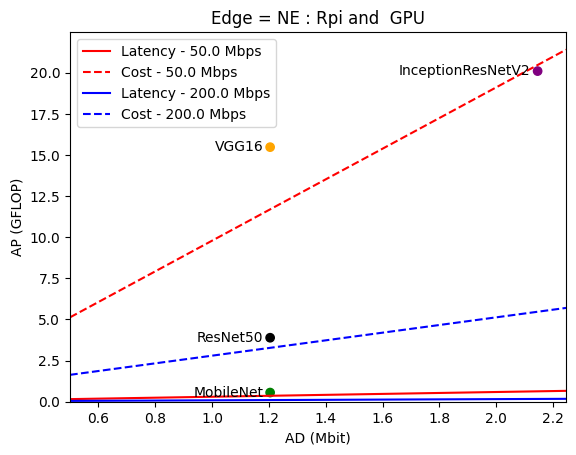

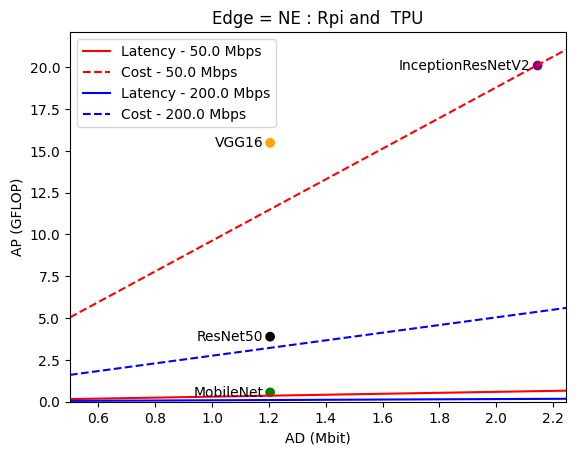

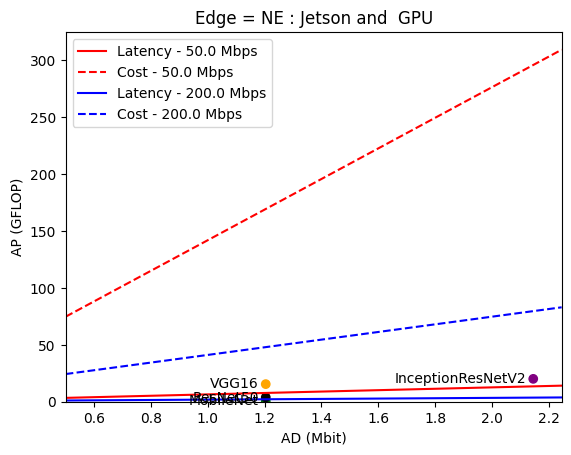

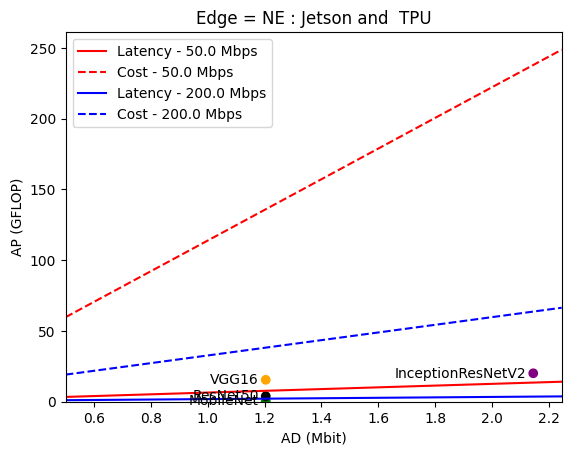

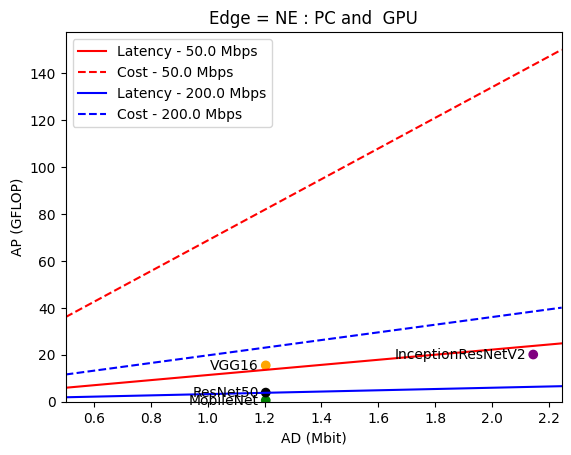

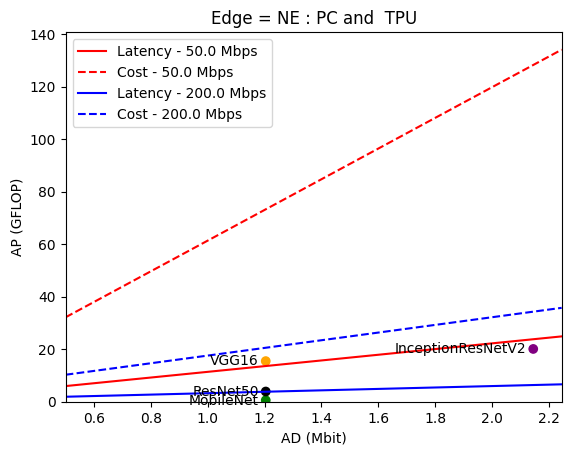

In [ ]:

BW_EetoNE_latency = np.linspace(50, 200, 2)[0:]

for inf in system:
    AP_latency_Edge_equal_NE = []
    AP_latency_Edge_equal_Cloud = []
    AP_latency_NE_equal_Cloud = []

    AP_cost_Edge_equal_NE = []
    AP_cost_Edge_equal_Cloud = []
    AP_cost_NE_equal_Cloud = []
    for bw in BW_EetoNE_latency:
      inf.EetoNE = bw
      inf.EetoC = bw
      if inf.check_condition():
          for AI in AD_Values:
              AP = inf.find_satisfying_AP_latency_AP_Edge_NE(AI)
              AP_latency_Edge_equal_NE.append(AP)

              # AP = inf.find_satisfying_AP_latency_AP_Edge_Cloud(AI)
              # AP_latency_Edge_equal_Cloud.append(AP)

              # AP = inf.find_satisfying_AP_latency_AP_NE_Cloud(AI)
              # AP_latency_NE_equal_Cloud.append(AP)

              AP = inf.find_satisfying_AP_cost_AP_Edge_NE(AI)
              AP_cost_Edge_equal_NE.append(AP)

              # AP = inf.find_satisfying_AP_cost_AP_Edge_Cloud(AI)
              # AP_cost_Edge_equal_Cloud.append(AP)


              # AP = inf.find_satisfying_AP_cost_AP_NE_Cloud(AI)
              # AP_cost_NE_equal_Cloud.append(AP)

    # print(AP_cost_NE_equal_Cloud)

    fig, ax1 = plt.subplots()

    ax1.plot(AD_Values, AP_latency_Edge_equal_NE[0:len(AD_Values)], 'r-', label = 'Latency - ' + str(BW_EetoNE_latency[0]) + ' Mbps')
    ax1.plot(AD_Values, AP_cost_Edge_equal_NE[0:len(AD_Values)], 'r--', label = 'Cost - ' + str(BW_EetoNE_latency[0]) + ' Mbps')
    ax1.plot(AD_Values, AP_latency_Edge_equal_NE[len(AD_Values):2*len(AD_Values)], 'b-', label = 'Latency - ' + str(BW_EetoNE_latency[1]) + ' Mbps')
    ax1.plot(AD_Values, AP_cost_Edge_equal_NE[len(AD_Values):2*len(AD_Values)], 'b--', label = 'Cost - ' + str(BW_EetoNE_latency[1]) + ' Mbps')
    # ax1.plot(AD_Values, AP_latency_Edge_equal_NE[2*len(AD_Values):3*len(AD_Values)], 'g-', label = 'Latency - ' + str(BW_EetoNE_latency[2]) + ' Mbps')
    # ax1.plot(AD_Values, AP_cost_Edge_equal_NE[2*len(AD_Values):3*len(AD_Values)], 'g--', label = 'Cost - ' + str(BW_EetoNE_latency[2]) + ' Mbps')



    ax1.set_xlabel('AD (Mbit)')
    ax1.set_ylabel('AP (GFLOP)')

    # Display legend
    lines, labels = ax1.get_legend_handles_labels()
    ax1.legend(lines, labels, loc='best')

    ax1.scatter(AD_models,AP_models, c=colors)
    for i, label in enumerate(labels_model):
        plt.annotate(label, (AD_models[i], AP_models[i]), xytext=(-5, 5), textcoords='offset points', ha='right', va='top')

    plt.xlim(left=AD_Values[0])
    plt.xlim(right=AD_Values[-1])
    plt.ylim(bottom=0)

    plt.title('Edge = NE : ' + Device[inf.edge] + ' and ' + NE[inf.ne])
    # Save the first plot
    # plt.savefig('Edge = NE : ' + Device[inf.edge] + ' and ' + NE[inf.ne])
    plt.show()

# Effect of changing bandwidth

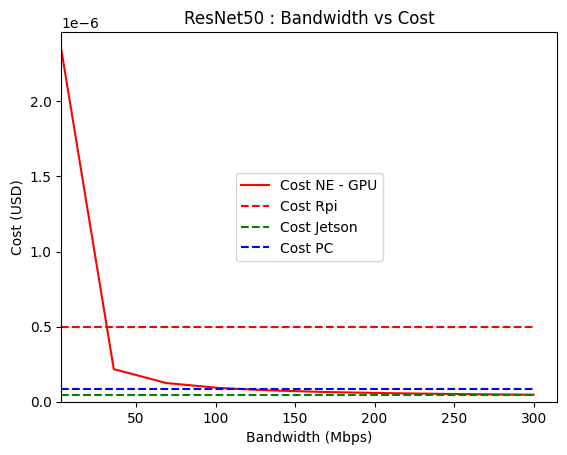

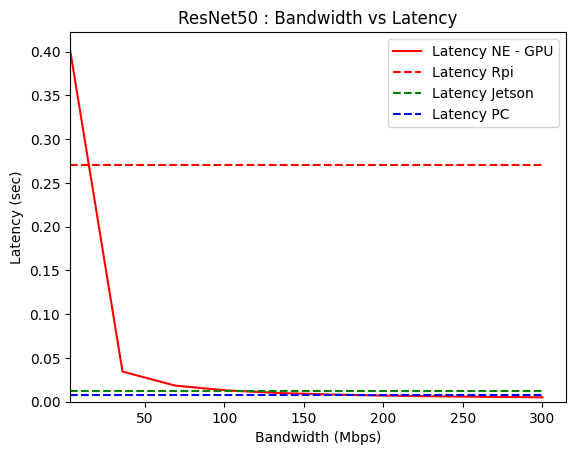

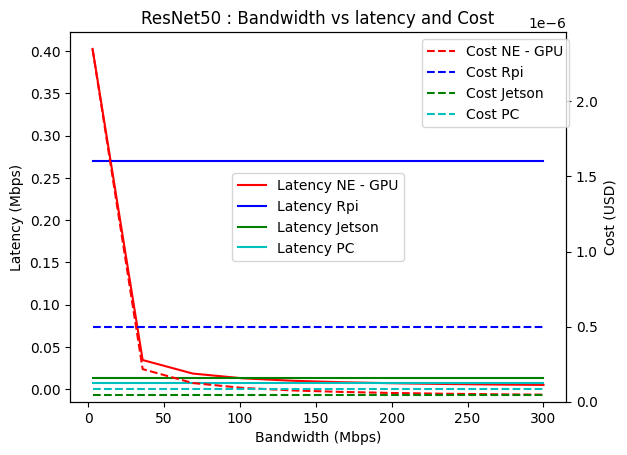

In [ ]:
NTrC = 5.787 * 10 ** -6 # CAD Bell
NTrc = 7.716 * 10 ** -6 # USD AT&T
latency_Edge_equal_NE = []
latency_Edge_equal_Cloud = []
latency_NE_equal_Cloud = []

latency_Rpi = []
latency_Jetson = []
latency_PC = []

cost_Rpi = []
cost_Jetson = []
cost_PC = []

for model in Models:
    latency_Rpi.append(model.sum/(Rpi[0]*Utilization_Edge))
    latency_Jetson.append(model.sum/(Jetson[0]*Utilization_Edge))
    latency_PC.append(model.sum/(PC[0]*Utilization_Edge))
    cost_Rpi.append((Rpi[3] * model.sum)/(Rpi[0]*Utilization_Edge))
    cost_Jetson.append((Jetson[3] * model.sum)/(Jetson[0]*Utilization_Edge))
    cost_PC.append((PC[3] * model.sum)/(PC[0]*Utilization_Edge))

# BW_EetoNE_latency = np.linspace(3, 200, 10)[0:]
# BW_EetoNE_cost = np.linspace(10, 300, 10)[0:]

BW_EetoNE_latency = np.linspace(3, 300, 10)[0:]
BW_EetoNE_cost = np.linspace(3, 300, 10)[0:]

ind = 0


for model in Models:
    latency_NE_CPU = []
    latency_NE_GPU = []
    latency_NE_TPU = []
    latency_model_Rpi = []
    latency_model_Jetson = []
    latency_model_PC = []

    cost_NE_CPU = []
    cost_NE_GPU = []
    cost_NE_TPU = []
    cost_model_Rpi = []
    cost_model_Jetson = []
    cost_model_PC = []
    for inf in system:
        if inf.edge == 0 and inf.ne == 1 and inf.cloud == 1:
            for i in range(len(BW_EetoNE_latency)):
                inf.EetoNE = BW_EetoNE_latency[i]
                latency_NE_GPU.append(inf.compute_latency_NE(model.sum,model.layer_AI[0]))
                latency_model_Rpi.append(latency_Rpi[ind])
                latency_model_Jetson.append(latency_Jetson[ind])
                latency_model_PC.append(latency_PC[ind])

                inf.EetoNE = BW_EetoNE_cost[i]
                cost_NE_GPU.append(inf.compute_cost_NE(model.sum,model.layer_AI[0]))
                cost_model_Rpi.append(cost_Rpi[ind])
                cost_model_Jetson.append(cost_Jetson[ind])
                cost_model_PC.append(cost_PC[ind])

        elif inf.edge == 0 and inf.ne == 2 and inf.cloud == 2:
            for i in range(len(BW_EetoNE_latency)):
                inf.EetoNE = BW_EetoNE_latency[i]
                latency_NE_TPU.append(inf.compute_latency_NE(model.sum,model.layer_AI[0]))
                inf.EetoNE = BW_EetoNE_cost[i]
                cost_NE_TPU.append(inf.compute_cost_NE(model.sum,model.layer_AI[0]))

        elif inf.ne == 0:
            for i in range(len(BW_EetoNE_latency)):
                inf.EetoNE = BW_EetoNE_latency[i]
                latency_NE_CPU.append(inf.compute_latency_NE(model.sum,model.layer_AI[0]))
                inf.EetoNE = BW_EetoNE_cost[i]
                cost_NE_CPU.append(inf.compute_cost_NE(model.sum,model.layer_AI[0]))

        # print(cost_Rpi)
    inf = Infrastructure(0,0,0,Utilization_Edge,Utilization_NE,EetoNE,EetoC,EetoC,PDEtoNE,PDEtoC)
    for i in range(len(BW_EetoNE_latency)):
                inf.EetoNE = BW_EetoNE_latency[i]
                latency_NE_CPU.append(inf.compute_latency_NE(model.sum,model.layer_AI[0]))
                inf.EetoNE = BW_EetoNE_cost[i]
                cost_NE_CPU.append(inf.compute_cost_NE(model.sum,model.layer_AI[0]))

    if model.name == "ResNet50":
        fig, ax1 = plt.subplots()
        # ax2 = ax1.twinx()

        ax1.plot(BW_EetoNE_cost, cost_NE_GPU, 'r-', label = 'Cost NE - GPU')
        # ax1.plot(BW_EetoNE_cost, cost_NE_TPU, 'b-', label = 'Cost NE - TPU')
        # ax1.plot(BW_EetoNE_cost, cost_NE_CPU, 'g-', label = 'Cost NE - CPU')
        ax1.plot(BW_EetoNE_cost, cost_model_Rpi, 'r--', label = 'Cost Rpi')
        ax1.plot(BW_EetoNE_cost, cost_model_Jetson, 'g--', label = 'Cost Jetson')
        ax1.plot(BW_EetoNE_cost, cost_model_PC, 'b--', label = 'Cost PC')

        ax1.set_xlabel('Bandwidth (Mbps)')
        ax1.set_ylabel('Cost (USD)')
        # ax2.set_ylabel('Cost (USD)')

        # Display legend
        lines, labels = ax1.get_legend_handles_labels()
        ax1.legend(lines, labels, loc='center')

        plt.xlim(left=BW_EetoNE_cost[0])
        # plt.xlim(right=AD_Values[-1])
        plt.ylim(bottom=0)

        plt.title(model.name + " : Bandwidth vs Cost")
        # Save the first plot
        # plt.savefig(model.name  + " : Bandwidth vs Cost")
        plt.show()

        fig, ax1 = plt.subplots()
        # ax2 = ax1.twinx()

        ax1.plot(BW_EetoNE_latency, latency_NE_GPU, 'r-', label = 'Latency NE - GPU')
        # ax1.plot(BW_EetoNE_latency, latency_NE_TPU, 'b-', label = 'Latency NE - TPU')
        # ax1.plot(BW_EetoNE_latency, latency_NE_CPU, 'g-', label = 'Latency NE - CPU')
        ax1.plot(BW_EetoNE_latency, latency_model_Rpi, 'r--', label = 'Latency Rpi')
        ax1.plot(BW_EetoNE_latency, latency_model_Jetson, 'g--', label = 'Latency Jetson')
        ax1.plot(BW_EetoNE_latency, latency_model_PC, 'b--', label = 'Latency PC')


        ax1.set_xlabel('Bandwidth (Mbps)')
        ax1.set_ylabel('Latency (sec)')
        # ax2.set_ylabel('Cost (USD)')

        # Display legend
        lines, labels = ax1.get_legend_handles_labels()
        ax1.legend(lines, labels, loc='best')

        plt.xlim(left=BW_EetoNE_latency[0])
        # plt.xlim(right=AD_Values[-1])
        plt.ylim(bottom=0)

        plt.title(model.name + " : Bandwidth vs Latency" )
        # Save the first plot
        # plt.savefig(model.name  + " : Bandwidth vs Latency")
        plt.show()

        fig, ax1 = plt.subplots()
        ax2 = ax1.twinx()

        ax1.plot(BW_EetoNE_latency, latency_NE_GPU, 'r-', label = 'Latency NE - GPU')
        # ax1.plot(BW_EetoNE_latency, latency_NE_TPU, 'b-', label = 'Latency NE - TPU')
        # ax1.plot(BW_EetoNE_latency, latency_NE_CPU, 'g-', label = 'Latency NE - CPU')
        ax1.plot(BW_EetoNE_latency, latency_model_Rpi, 'b-', label = 'Latency Rpi')
        ax1.plot(BW_EetoNE_latency, latency_model_Jetson, 'g-', label = 'Latency Jetson')
        ax1.plot(BW_EetoNE_latency, latency_model_PC, 'c-', label = 'Latency PC')

        ax2.plot(BW_EetoNE_cost, cost_NE_GPU, 'r--', label = 'Cost NE - GPU')
        # ax1.plot(BW_EetoNE_cost, cost_NE_TPU, 'b-', label = 'Cost NE - TPU')
        # ax1.plot(BW_EetoNE_cost, cost_NE_CPU, 'g-', label = 'Cost NE - CPU')
        ax2.plot(BW_EetoNE_cost, cost_model_Rpi, 'b--', label = 'Cost Rpi')
        ax2.plot(BW_EetoNE_cost, cost_model_Jetson, 'g--', label = 'Cost Jetson')
        ax2.plot(BW_EetoNE_cost, cost_model_PC, 'c--', label = 'Cost PC')

        ax1.set_xlabel('Bandwidth (Mbps)')
        ax1.set_ylabel('Latency (Mbps)')
        ax2.set_ylabel('Cost (USD)')

        # Display legend
        lines, labels = ax1.get_legend_handles_labels()
        ax1.legend(lines, labels, loc='center')
        lines, labels = ax2.get_legend_handles_labels()
        ax2.legend(lines, labels, loc='upper right',  bbox_to_anchor=(1.02, 1.0))


        # plt.xlim(left=BW_EetoNE_cost[0])
        # plt.xlim(right=AD_Values[-1])
        plt.ylim(bottom=0)

        plt.title(model.name + " : Bandwidth vs latency and Cost")
        # Save the first plot
        # plt.savefig(model.name  + " : Bandwidth vs Cost")
        plt.show()

    ind = ind+1

# Effect for changing batch size

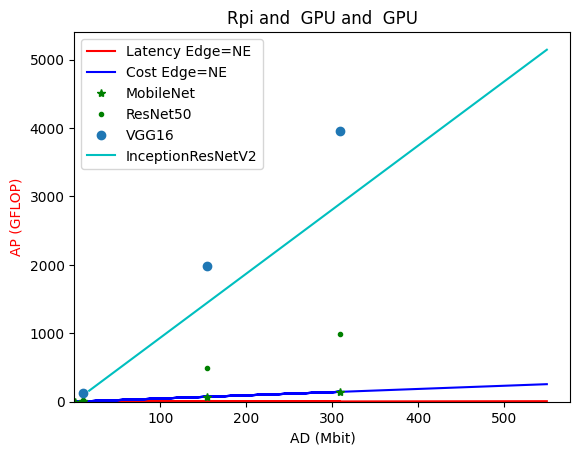

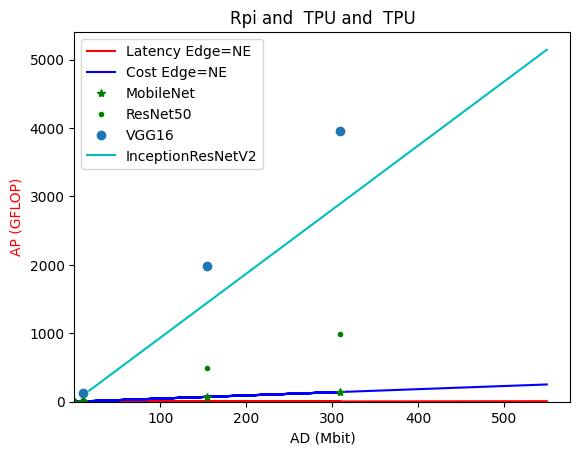

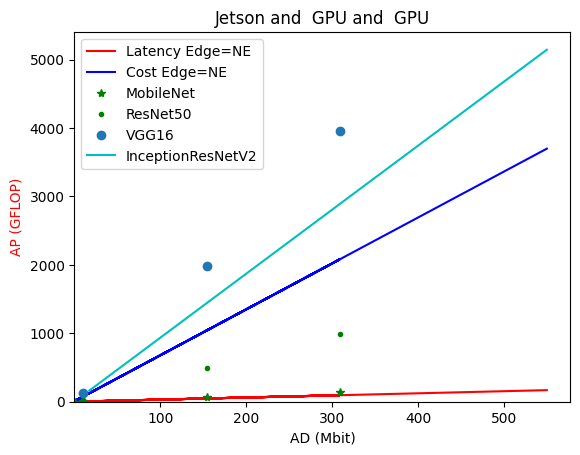

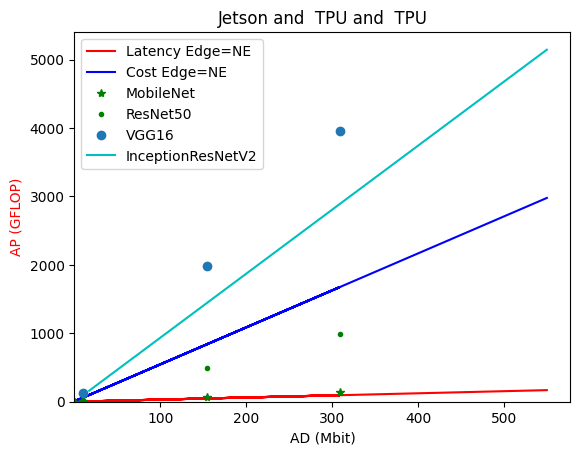

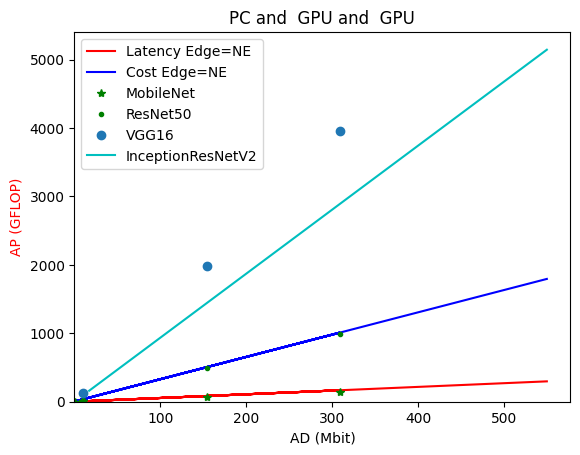

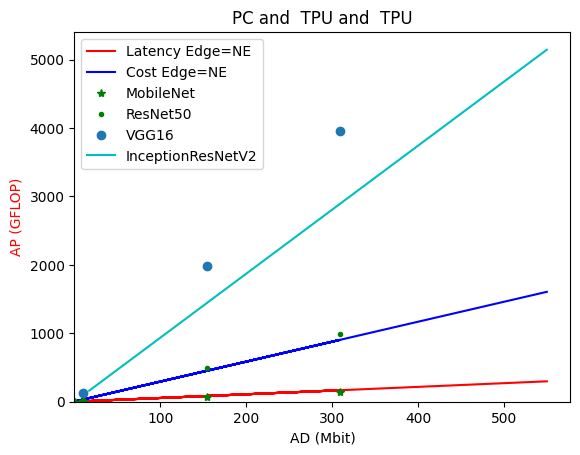

In [ ]:
AP_models = []
AD_models = []
AD_Values = [0.01]
Batch_Size = [1, 8, 128, 256]
colors = ['green', 'black', 'orange', 'purple']
x = 1
labels_model = []
for ind in range(len(Models)):
    for size in Batch_Size:
        AP_models.append(x * size * sum(Models[ind].layer_AP[0:len(Models[ind].layer_AP)]))
        AD_models.append(x * size * Models[ind].layer_AI[0])
        AD_Values.append(x * size * Models[ind].layer_AI[0])
    labels_model.append(Models[ind].name)
# print(labels_model)
AD_Values.append(2*x*size * Models[ind-1].layer_AI[0])



for inf in system:
    AP_latency_Edge_equal_NE = []
    AP_latency_Edge_equal_Cloud = []
    AP_latency_NE_equal_Cloud = []

    AP_cost_Edge_equal_NE = []
    AP_cost_Edge_equal_Cloud = []
    AP_cost_NE_equal_Cloud = []

    for AI in AD_models:
        AP = inf.find_satisfying_AP_latency_AP_Edge_NE(AI)
        AP_latency_Edge_equal_NE.append(AP)

        AP = inf.find_satisfying_AP_latency_AP_Edge_Cloud(AI)
        AP_latency_Edge_equal_Cloud.append(AP)

        AP = inf.find_satisfying_AP_latency_AP_NE_Cloud(AI)
        AP_latency_NE_equal_Cloud.append(AP)

        AP = inf.find_satisfying_AP_cost_AP_Edge_NE(AI)
        AP_cost_Edge_equal_NE.append(AP)

        AP = inf.find_satisfying_AP_cost_AP_Edge_Cloud(AI)
        AP_cost_Edge_equal_Cloud.append(AP)


        AP = inf.find_satisfying_AP_cost_AP_NE_Cloud(AI)
        AP_cost_NE_equal_Cloud.append(AP)

    fig, ax1 = plt.subplots()

    ax1.plot(AD_models, AP_latency_Edge_equal_NE, 'r-', label = 'Latency Edge=NE')
    # ax1.plot(AD_Values, AP_latency_Edge_equal_Cloud, 'g-', label = 'Latency Edge=Cloud')
    # ax1.plot(AD_Values, AP_latency_NE_equal_Cloud, 'b-', label = 'Latency NE=Cloud')

    ax1.plot(AD_models, AP_cost_Edge_equal_NE, 'b-', label = 'Cost Edge=NE')
    # ax1.plot(AD_Values, AP_cost_Edge_equal_Cloud, 'g*', label = 'Cost Edge=Cloud')
    # ax1.plot(AD_Values, AP_cost_NE_equal_Cloud, 'b*', label = 'Cost NE=Cloud')

    ax1.set_xlabel('AD (Mbit)')
    ax1.set_ylabel('AP (GFLOP)', color='r')



    ax1.plot(AD_models[0:len(Batch_Size)],AP_models[0:len(Batch_Size)],'g*', label = labels_model[0])
    ax1.plot(AD_models[len(Batch_Size)+1:2*len(Batch_Size)],AP_models[len(Batch_Size)+1:2*len(Batch_Size)],'g.', label = labels_model[1])
    ax1.plot(AD_models[2*len(Batch_Size)+1:3*len(Batch_Size)],AP_models[2*len(Batch_Size)+1:3*len(Batch_Size)],'o', label = labels_model[2])
    ax1.plot(AD_models[3*len(Batch_Size)+1:4*len(Batch_Size)],AP_models[3*len(Batch_Size)+1:4*len(Batch_Size)],'c-', label = labels_model[3])
    # for i, label in enumerate(labels_model):
    #     plt.annotate(label, (AD_models[0:len(Batch_Size)][i], AP_models[0:len(Batch_Size)][i]), xytext=(-5, 5), textcoords='offset points', ha='right', va='top')

    # Display legend
    lines, labels = ax1.get_legend_handles_labels()
    ax1.legend(lines, labels, loc='upper left')

    plt.xlim(left=AD_Values[0])
    # plt.xlim(right=AD_Values[-1])
    plt.ylim(bottom=0)

    plt.title(Device[inf.edge] + ' and ' + NE[inf.ne] + ' and ' + Cloud[inf.cloud])
    # Save the first plot
    # plt.savefig(device + '_' + NE + Cloud + '_latency.png')
    plt.show()


# Split algorithm for latency

In [ ]:
class minimum_Latency:
    def __init__(self,edge,NE,latency,cost):
        self.edge = edge
        self.NE = NE
        self.latency = latency
        self.cost = cost

def compute_sum(start,end):
        return sum(layer_AP[start:end])

def split_algorithm_latency(start, end):

    global latency_Edge
    global latency_Cloud
    global latency_NE
    global layer_values

    global AP_1
    global AP_2

    global cost_Edge
    global cost_Cloud
    global cost_NE

    AP = compute_sum(start,end)

    for layer in range(start,end):
        layer_values.append(layer)
        AI_l = layer_AI[layer]
        AP_Edge = compute_sum(layer,end)
        AP_1.append(AP-AP_Edge)
        AP_2.append(AP_Edge)
        latency_Edge.append(system.compute_latency_Edge(AP-AP_Edge))
        latency_NE.append(system.compute_latency_NE(AP_Edge,AI_l))
        latency_Cloud.append(system.compute_latency_Cloud(AP_Edge, AI_l))

        cost_Edge.append(system.compute_cost_Edge(AP-AP_Edge))
        cost_NE.append(system.compute_cost_NE(AP_Edge,AI_l))
        cost_Cloud.append(system.compute_cost_Cloud(AP_Edge, AI_l))
    # print(latency_Edge[::-1])
    print(latency_Edge)
    print(latency_NE)
    print(latency_Cloud)

    print(cost_Edge)
    print(cost_NE)
    print(cost_Cloud)

    # index = latency_NE.index(min(latency_NE))
    # print(index)
    # print(min(latency_NE))
    # print(latency_Edge[index-1])
    # print(layer_values)
    global optimal
    optimal = minimum_Latency(end,0,system.compute_latency_Edge(AP),system.compute_cost_Edge(AP))
    if latency_NE[0] < optimal.latency:
        optimal = minimum_Latency(-1,len(layer_AI),latency_NE[0],cost_NE[0])
        # print(optimal.compute_latency())
    if latency_Cloud[0] < optimal.latency:
        optimal = minimum_Latency(-1,-1,latency_Cloud[0])
        # print(optimal.compute_latency())
    for ind in layer_values[0:len(layer_values)]:
        lat1 = latency_Edge[ind] + latency_NE[ind]
        lat2 = latency_Edge[ind] + latency_Cloud[ind]
        cost1 = cost_Edge[ind] + cost_NE[ind]
        cost2 = cost_Edge[ind] + cost_Cloud[ind]

        # print(lat1)
        # print(lat2)
        if lat1 < lat2:
            if lat1 < optimal.latency:
                optimal = minimum_Latency(ind,len(layer_AI),lat1,cost1)
                print("lat1")
        elif lat2 < lat1:
            if lat2 < optimal.latency:
                # optimal = minimum_Latency(ind,ind,lat2,cost2)
                print("lat2")
            latency_NE_back = []
            latency_NE_Cloud = []
            AP_E =[]
            AP_NE = []
            AP_C = []

            for back in range(1,ind):
                AI_l = layer_AI[back]
                # AP_l = compute_sum(back,ind)
                AP_E.append(AP_1[back])
                AP_NE.append(AP_1[ind]-AP_1[back])
                AP_C.append(AP_2[ind])
                latency_NE_Cloud.append(system.compute_latency_NE_Cloud(AP_2[ind],layer_AI[ind]))
                latency_NE_back.append(system.compute_latency_NE(AP_1[ind]-AP_1[back],AI_l))
                value = latency_Edge[back] + system.compute_latency_NE(AP_1[ind]-AP_1[back],AI_l) + system.compute_latency_NE_Cloud(AP_2[ind],layer_AI[ind])
                cost = cost_Edge[back] + system.compute_cost_NE(AP_1[ind]-AP_1[back],AI_l) + system.compute_cost_NE_Cloud(AP_2[ind],layer_AI[ind])
                # print(value)
                if value < optimal.latency:
                    optimal = minimum_Latency(back,ind,value,cost)
                    print("here")
            # sum_AP = [(x + y + z) for x,y,z in zip(AP_E,AP_NE,AP_C)]
            # print(sum_AP)

# layer_AI = input
# layer_AI[0] = Batch_Size * layer_AI[0]
latency_Edge = []
latency_Cloud = []
latency_NE = []
layer_values = []
AP_1 = []
AP_2 = []
cost_Edge = []
cost_Cloud = []
cost_NE = []

Batch_Size1 = 8
Batch_Size2 = 16
Batch_Size3 = 8

# layer_AP =   [Batch_Size1 * x for x in ResNet152.layer_AP] + [Batch_Size1 * x for x in ResNet50.layer_AP] + [Batch_Size2 * x for x in InceptionResNetV2.layer_AP] + [Batch_Size3 * x for x in ResNet152.layer_AP]
# layer_AI =   [Batch_Size1 * x for x in ResNet152.layer_AI] + [Batch_Size1 * x for x in ResNet50.layer_AI] + [Batch_Size2 * x for x in InceptionResNetV2.layer_AI] + [Batch_Size3 * x for x in ResNet152.layer_AI]

# layer_AP = ResNet50.layer_AP
# layer_AI = ResNet50.layer_AI

# layer_AP = InceptionResNetV2.layer_AP
# layer_AI = InceptionResNetV2.layer_AI

layer_AP =  [Batch_Size1 * x for x in ResNet50.layer_AP]
layer_AI =  [Batch_Size1 * x for x in ResNet50.layer_AI]

# layer_AP =  [Batch_Size1 * x for x in ResNet152.layer_AP]
# layer_AI =  [Batch_Size1 * x for x in ResNet152.layer_AI]

# layer_AP =  [Batch_Size1 * x for x in InceptionResNetV2.layer_AP]
# layer_AI =  [Batch_Size1 * x for x in InceptionResNetV2.layer_AI]

# system.EetoNE = 322  # ResNet50
system.EetoNE = 20
system.NEtoC = 4
system.EetoC = 4
# print(optimal.compute_latency())
split_algorithm_latency(0,len(layer_AI))
print("edge = " + str(optimal.edge) + " : NE = " + str(optimal.NE))
print(optimal.latency)
print(optimal.cost)
print(len(layer_AP))

[0.0, 0.0020070400000000215, 0.06757034666666625, 0.06757041777777732, 0.06801642666666607, 0.07158449777777737, 0.07258801777777737, 0.07972415999999946, 0.07972423111111078, 0.07983573333333278, 0.144061013333333, 0.1440610844444443, 0.1441725866666663, 0.17271715555555486, 0.20126172444444393, 0.20126200888888848, 0.20126229333333276, 0.20215431111111054, 0.20260031999999953, 0.23114488888888834, 0.23114495999999943, 0.23125646222222168, 0.2954817422222216, 0.2954818133333327, 0.29559331555555496, 0.3241378844444435, 0.3241381688888881, 0.32503018666666583, 0.32547619555555485, 0.35402076444444364, 0.3540208355555547, 0.354132337777777, 0.4183576177777769, 0.41835768888888797, 0.41846919111111025, 0.4470137599999988, 0.44701404444444337, 0.4479060622222211, 0.44835207111111014, 0.46262435555555453, 0.46262449777777664, 0.4626802488888878, 0.5269055288888875, 0.5269056711111096, 0.5269614222222208, 0.5840505599999984, 0.6125951288888877, 0.6125956977777766, 0.6125962666666653, 0.6130

# Split Algorithm for cost

In [ ]:
class minimum_cost:
    def __init__(self,edge,NE,latency,cost):
        self.edge = edge
        self.NE = NE
        self.latency = latency
        self.cost = cost


def compute_sum(start,end):
        return sum(layer_AP[start:end])

def split_algorithm_cost(start, end):

    global cost_Edge
    global cost_Cloud
    global cost_NE
    global layer_values

    global AP_1
    global AP_2

    global latency_Edge
    global latency_Cloud
    global latency_NE

    AP = compute_sum(start,end)

    for layer in range(start,end):
        layer_values.append(layer)
        AI_l = layer_AI[layer]
        AP_Edge = compute_sum(layer,end)
        AP_1.append(AP-AP_Edge)
        AP_2.append(AP_Edge)
        cost_Edge.append(system.compute_cost_Edge(AP-AP_Edge))
        cost_NE.append(system.compute_cost_NE(AP_Edge,AI_l))
        cost_Cloud.append(system.compute_cost_Cloud(AP_Edge, AI_l))

        latency_Edge.append(system.compute_latency_Edge(AP-AP_Edge))
        latency_NE.append(system.compute_latency_NE(AP_Edge,AI_l))
        latency_Cloud.append(system.compute_latency_Cloud(AP_Edge, AI_l))

    print(latency_Edge)
    print(latency_NE)
    print(latency_Cloud)

    print(cost_Edge)
    print(cost_NE)
    print(cost_Cloud)

    # index = cost_NE.index(min(cost_NE))
    # print(index)
    # print(min(cost_NE))
    # print(cost_Edge[index-1])
    # print(layer_values)
    global optimal
    optimal = minimum_cost(end,0,system.compute_latency_Edge(AP),system.compute_cost_Edge(AP))
    if cost_NE[0] < optimal.cost:
        optimal = minimum_cost(-1,len(layer_AI),latency_NE[0], cost_NE[0])
        # print(optimal.compute_cost())
    if cost_Cloud[0] < optimal.cost:
        optimal = minimum_cost(-1,-1,latency_Cloud[0],cost_Cloud[0])
        # print(optimal.compute_cost())
    for ind in layer_values[0:len(layer_values)]:
        lat1 = latency_Edge[ind] + latency_NE[ind]
        lat2 = latency_Edge[ind] + latency_Cloud[ind]
        cost1 = cost_Edge[ind] + cost_NE[ind]
        cost2 = cost_Edge[ind] + cost_Cloud[ind]
        # print(lat1)
        # print(lat2)
        if cost1 < cost2:
            if cost1 < optimal.cost:
                optimal = minimum_cost(ind,len(layer_AI),lat1,cost1)
                print("cost1")
        elif cost2 < cost1:
            if cost2 < optimal.cost:
                # optimal = minimum_cost(ind,ind,lat2,cost2)
                print("cost2")
            cost_NE_back = []
            cost_NE_Cloud = []
            AP_E =[]
            AP_NE = []
            AP_C = []

            for back in range(1,ind):
                AI_l = layer_AI[back]
                # AP_l = compute_sum(back,ind)
                AP_E.append(AP_1[back])
                AP_NE.append(AP_1[ind]-AP_1[back])
                AP_C.append(AP_2[ind])
                cost_NE_Cloud.append(system.compute_cost_NE_Cloud(AP_2[ind],layer_AI[ind]))
                cost_NE_back.append(system.compute_cost_NE(AP_1[ind]-AP_1[back],AI_l))
                latency = latency_Edge[back] + system.compute_latency_NE(AP_1[ind]-AP_1[back],AI_l) + system.compute_latency_NE_Cloud(AP_2[ind],layer_AI[ind])
                value = cost_Edge[back] + system.compute_cost_NE(AP_1[ind]-AP_1[back],AI_l) + system.compute_cost_NE_Cloud(AP_2[ind],layer_AI[ind])
                # print(value)
                if value < optimal.cost:
                    optimal = minimum_cost(back,ind,latency,value)
                    print("here")
            # sum_AP = [(x + y + z) for x,y,z in zip(AP_E,AP_NE,AP_C)]
            # print(sum_AP)

# layer_AI = input
# layer_AI[0] = Batch_Size * layer_AI[0]
cost_Edge = []
cost_Cloud = []
cost_NE = []
layer_values = []
latency_Edge = []
latency_Cloud = []
latency_NE = []
layer_values = []
AP_1 = []
AP_2 = []

Batch_Size1 = 1
Batch_Size2 = 16
Batch_Size3 = 8

# layer_AP =   [Batch_Size1 * x for x in ResNet152.layer_AP] + [Batch_Size1 * x for x in ResNet50.layer_AP] + [Batch_Size2 * x for x in InceptionResNetV2.layer_AP] + [Batch_Size3 * x for x in ResNet152.layer_AP]
# layer_AI =   [Batch_Size1 * x for x in ResNet152.layer_AI] + [Batch_Size1 * x for x in ResNet50.layer_AI] + [Batch_Size2 * x for x in InceptionResNetV2.layer_AI] + [Batch_Size3 * x for x in ResNet152.layer_AI]

# layer_AP = ResNet50.layer_AP
# layer_AI = ResNet50.layer_AI

# layer_AP = InceptionResNetV2.layer_AP
# layer_AI = InceptionResNetV2.layer_AI

# layer_AP =  [Batch_Size1 * x for x in ResNet50.layer_AP]
# layer_AI =  [Batch_Size1 * x for x in ResNet50.layer_AI]

# layer_AP =  [Batch_Size1 * x for x in ResNet152.layer_AP]
# layer_AI =  [Batch_Size1 * x for x in ResNet152.layer_AI]

layer_AP =  [Batch_Size1 * x for x in InceptionResNetV2.layer_AP]
layer_AI =  [Batch_Size1 * x for x in InceptionResNetV2.layer_AI]

# system.EetoNE = 322  # ResNet50
system.EetoNE = 30
# system.NEtoC = 300
system.UtilizationNE = 0.2
# print(optimal.compute_cost())
layer_AI.append(0)
split_algorithm_cost(0,len(layer_AI))
print("edge = " + str(optimal.edge) + " : NE = " + str(optimal.NE))
print(optimal.latency)
print(optimal.cost)

print(len(layer_AP))

[0.0, 0.0013320599999998449, 0.0013320644444444105, 0.0013813999999998416, 0.01521115999999983, 0.015211164444444395, 0.015259184444444223, 0.04291870444444444, 0.04291871333333333, 0.04301475333333323, 0.04322791333333341, 0.04512266888888888, 0.04512267999999992, 0.04515228555555566, 0.09354588555555562, 0.09354591222222228, 0.09361312555555563, 0.0937601255555556, 0.0948054588888889, 0.09480546777777778, 0.0948109122222222, 0.09559491222222229, 0.1002989122222221, 0.10029891888888884, 0.10029893222222229, 0.10030301555555547, 0.10031118222222234, 0.10187918222222228, 0.10841251555555549, 0.11546851555555558, 0.11651384888888888, 0.11651386222222208, 0.11651387111111097, 0.11651388444444442, 0.1165138933333333, 0.11652205999999993, 0.11652750444444435, 0.11653567111111096, 0.11654111555555538, 0.11741222666666662, 0.11741223111111095, 0.11741495333333316, 0.1182860644444444, 0.11946206444444465, 0.11946206888888922, 0.11946207555555595, 0.11946479777777816, 0.11946888111111134, 0.120

# Store splits within deadline and budget constraints

In [ ]:
class store_splits:
   def __init__(self):
      self.op = []
   def store(self,optimal)
      self.op.append(optimal)

class minimum_split:
    def __init__(self,edge,NE,latency,cost):
        self.edge = edge
        self.NE = NE
        self.latency = latency
        self.cost = cost


def compute_sum(start,end):
        return sum(layer_AP[start:end])

def split_algorithm_cost(start, end):

    global cost_Edge
    global cost_Cloud
    global cost_NE
    global layer_values

    global AP_1
    global AP_2

    global latency_Edge
    global latency_Cloud
    global latency_NE

    AP = compute_sum(start,end)

    for layer in range(start,end):
        layer_values.append(layer)
        AI_l = layer_AI[layer]
        AP_Edge = compute_sum(layer,end)
        AP_1.append(AP-AP_Edge)
        AP_2.append(AP_Edge)
        cost_Edge.append(system.compute_cost_Edge(AP-AP_Edge))
        cost_NE.append(system.compute_cost_NE(AP_Edge,AI_l))
        cost_Cloud.append(system.compute_cost_Cloud(AP_Edge, AI_l))

        latency_Edge.append(system.compute_latency_Edge(AP-AP_Edge))
        latency_NE.append(system.compute_latency_NE(AP_Edge,AI_l))
        latency_Cloud.append(system.compute_latency_Cloud(AP_Edge, AI_l))

    print(latency_Edge)
    print(latency_NE)
    print(latency_Cloud)

    print(cost_Edge)
    print(cost_NE)
    print(cost_Cloud)

    # index = cost_NE.index(min(cost_NE))
    # print(index)
    # print(min(cost_NE))
    # print(cost_Edge[index-1])
    # print(layer_values)
    global optimal
    optimal = minimum_split(end,0,system.compute_latency_Edge(AP),system.compute_cost_Edge(AP))
    if cost_NE[0] < optimal.cost:
        optimal = minimum_split(-1,len(layer_AI),latency_NE[0], cost_NE[0])
        # print(optimal.compute_cost())
    if cost_Cloud[0] < optimal.cost:
        optimal = minimum_split(-1,-1,latency_Cloud[0],cost_Cloud[0])
        # print(optimal.compute_cost())
    for ind in layer_values[0:len(layer_values)]:
        lat1 = latency_Edge[ind] + latency_NE[ind]
        lat2 = latency_Edge[ind] + latency_Cloud[ind]
        cost1 = cost_Edge[ind] + cost_NE[ind]
        cost2 = cost_Edge[ind] + cost_Cloud[ind]
        # print(lat1)
        # print(lat2)
        if cost1 < cost2:
            if cost1 < optimal.cost:
                optimal = minimum_split(ind,len(layer_AI),lat1,cost1)
                print("cost1")
        elif cost2 < cost1:
            if cost2 < optimal.cost:
                # optimal = minimum_cost(ind,ind,lat2,cost2)
                print("cost2")
            cost_NE_back = []
            cost_NE_Cloud = []
            AP_E =[]
            AP_NE = []
            AP_C = []

            for back in range(1,ind):
                AI_l = layer_AI[back]
                # AP_l = compute_sum(back,ind)
                AP_E.append(AP_1[back])
                AP_NE.append(AP_1[ind]-AP_1[back])
                AP_C.append(AP_2[ind])
                cost_NE_Cloud.append(system.compute_cost_NE_Cloud(AP_2[ind],layer_AI[ind]))
                cost_NE_back.append(system.compute_cost_NE(AP_1[ind]-AP_1[back],AI_l))
                latency = latency_Edge[back] + system.compute_latency_NE(AP_1[ind]-AP_1[back],AI_l) + system.compute_latency_NE_Cloud(AP_2[ind],layer_AI[ind])
                value = cost_Edge[back] + system.compute_cost_NE(AP_1[ind]-AP_1[back],AI_l) + system.compute_cost_NE_Cloud(AP_2[ind],layer_AI[ind])
                # print(value)
                if value < optimal.cost:
                    optimal = minimum_split(back,ind,latency,value)
                    print("here")
            # sum_AP = [(x + y + z) for x,y,z in zip(AP_E,AP_NE,AP_C)]
            # print(sum_AP)

# layer_AI = input
# layer_AI[0] = Batch_Size * layer_AI[0]


cost_Edge = []
cost_Cloud = []
cost_NE = []
layer_values = []
latency_Edge = []
latency_Cloud = []
latency_NE = []
layer_values = []
AP_1 = []
AP_2 = []

Batch_Size1 = 1
Batch_Size2 = 16
Batch_Size3 = 8

# layer_AP =   [Batch_Size1 * x for x in ResNet152.layer_AP] + [Batch_Size1 * x for x in ResNet50.layer_AP] + [Batch_Size2 * x for x in InceptionResNetV2.layer_AP] + [Batch_Size3 * x for x in ResNet152.layer_AP]
# layer_AI =   [Batch_Size1 * x for x in ResNet152.layer_AI] + [Batch_Size1 * x for x in ResNet50.layer_AI] + [Batch_Size2 * x for x in InceptionResNetV2.layer_AI] + [Batch_Size3 * x for x in ResNet152.layer_AI]

# layer_AP = ResNet50.layer_AP
# layer_AI = ResNet50.layer_AI

# layer_AP = InceptionResNetV2.layer_AP
# layer_AI = InceptionResNetV2.layer_AI

# layer_AP =  [Batch_Size1 * x for x in ResNet50.layer_AP]
# layer_AI =  [Batch_Size1 * x for x in ResNet50.layer_AI]

# layer_AP =  [Batch_Size1 * x for x in ResNet152.layer_AP]
# layer_AI =  [Batch_Size1 * x for x in ResNet152.layer_AI]

layer_AP =  [Batch_Size1 * x for x in InceptionResNetV2.layer_AP]
layer_AI =  [Batch_Size1 * x for x in InceptionResNetV2.layer_AI]

database = store_splits()
database.store(optimal)
# system.EetoNE = 322  # ResNet50
system.EetoNE = 30
# system.NEtoC = 300
system.UtilizationNE = 0.2
# print(optimal.compute_cost())
layer_AI.append(0)
split_algorithm_cost(0,len(layer_AI))
print("edge = " + str(optimal.edge) + " : NE = " + str(optimal.NE))
print(optimal.latency)
print(optimal.cost)

print(len(layer_AP))

# Bert

In [ ]:
# !pip install transformers
from transformers import TFBertModel, BertTokenizer

# Load the BERT model and tokenizer
model_name = "bert-base-uncased"
tokenizer = BertTokenizer.from_pretrained(model_name)
# model = TFBertModel.from_pretrained(model_name)

text = "This is an example sentence. This is an example sentence. This is an example sentence."
inputs = tokenizer(text, return_tensors="pt")

input_size = inputs.input_ids.size()
print("Input Size: (Mbit)", input_size[0]*input_size[1]/1000000)

# Instantiate the Bert model
# BertModel = Model("BertModel",model)
# BertModel.compute_model()

# Use a random input sequence (replace it with your tokenized input)
input_ids = tf.constant([[101, 2023, 2003, 2019, 2742, 102]])


# @tf.function
# def profile_model(model, input_tensor):
#     return model(input_tensor)

# result = profile_model(model, input_ids)
# tf.profiler.profile(result.numpy())

# Wrap the model call in a tf.function
@tf.function
def call_model(inputs):
    return model(inputs)

# Run the model once to trace the graph
_ = call_model(inputs)

# Profile the GFLOPs using graph execution
run_meta = tf.compat.v1.RunMetadata()
with tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph()) as sess:
    _ = sess.run(model(inputs), options=tf.compat.v1.RunOptions(trace_level=tf.compat.v1.RunOptions.FULL_TRACE), run_metadata=run_meta)

gflops = tf.compat.v1.profiler.profile(run_meta=run_meta, options=tf.compat.v1.profiler.ProfileOptionBuilder.float_operation())
print("Total GFLOPs:", gflops.total_float_ops)





Input Size: (Mbit) 2e-05


ValueError: ignored